In [1]:
''' 
A note to other users:

This is roughly broken into 3 sections: The data_gathering() section which 
pulls data from the text files (stored in ../data , a directory just outside
of the directory that this program is being ran from), the data_analysis() section
which removes jump artifacts (an on-off happening at the same time, which is meaningless
to the evolution but is a side effect of allowing for more jumps than expected), and the
plot_data() section. These are called in order from a 'main' below the three sections. Keep in mind that
jupyter keeps the most recently ran declaration/definition, so if you're making a change to a
data_analysis() function for example, you must rerun that cell (shift+ENTER for most computers) in order
for those changes to show up when calling 'main'. Similarly, if this is your first time opening the notebook
for the day, you must run all of the cells in order for them to be loaded into memory.
'''

" \nA note to other users:\n\nThis is roughly broken into 3 sections: The data_gathering() section which \npulls data from the text files (stored in ../data , a directory just outside\nof the directory that this program is being ran from), the data_analysis() section\nwhich removes jump artifacts (an on-off happening at the same time, which is meaningless\nto the evolution but is a side effect of allowing for more jumps than expected), and the\nplot_data() section. These are called in order from a 'main' below the three sections. Keep in mind that\njupyter keeps the most recently ran declaration/definition, so if you're making a change to a\ndata_analysis() function for example, you must rerun that cell (shift+ENTER for most computers) in order\nfor those changes to show up when calling 'main'. Similarly, if this is your first time opening the notebook\nfor the day, you must run all of the cells in order for them to be loaded into memory.\n"

In [2]:
import sys
import os
import shutil
import errno
from glob import glob
from decimal import Decimal
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import glob
import re
from IPython.display import set_matplotlib_formats
from ast import literal_eval

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 7,5
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

#cmap=plt.cm.viridis
cmap=plt.cm.coolwarm

# Single Data Set Class

In [40]:
class data_set:
    def __init__(self, filepath):     
        params, data_for_file = get_params(filepath), get_data(filepath)

        self.filepath = filepath
        self.sim_type, self.dim, self.occ =  (filepath.split("___")[0])[len(filepath.split("___")[0])-4:], int((filepath.split("x")[0])[-1]), int((filepath.split("_occupants")[0])[-1])
        self.ji, self.ki, self.jt, self.kt = float(get_values(params, "j_initial")), float(get_values(params, "k_initial")), float(get_values(params, "j_target")), float(get_values(params, "k_target"))
        self.initial_e, self.ground_e = float(get_values(params, "INITIAL_E")), float(get_values(params, "GROUND_E"))
        self.initial_state, self.target_state = get_values(params, "init_state"), get_values(params, "target_state") 
        self.init_target_dot_squared, self.num_seeds =float(get_values(params, "init_target_dot_squared")), int(get_values(params, "NUM_SEEDS"))
        self.tau_initial, self.max_tau = float(get_values(params, "TAU_INIT")), float(get_values(params, "MAX_TAU"))
        self.energy_space = bool(get_values(params, "USE_ENERGY_DISTANCE"))  
        
        
        self.j_protocols               = get_values(data_for_file, "j_protocols")
        self.k_protocols               = get_values(data_for_file, "k_protocols")
        self.tau_array                 = get_values(data_for_file, "tau_array")
        self.best_mc_result_array      = get_values(data_for_file, "best_mc_result_array")
        self.distance_array            = get_values(data_for_file, "distance_array")
        self.best_mc_result_fixed_tau_array    = get_values(data_for_file, "best_mc_result_fixed_tau_array")
        self.total_steps_array         = get_values(data_for_file, "total_steps_array")
        self.time_step_array           = get_values(data_for_file, "time_step_array")
        self.clock_array               = get_values(data_for_file, "clock_array")
        self.overlap_array             = get_values(data_for_file, "overlap_array")
        self.best_state_array          = get_values(data_for_file, "best_state_array")
        self.evolved_state_fixed_tau   = get_values(data_for_file, "evolved_state_fixed_tau")
        
        self.tau_critical              = self.tau_array[-1]
        if(self.tau_critical == 0): self.skip = True
        else: self.skip = False
        self.tau_extrapolated = 0
        self.j_protocols_reduced, self.k_protocols_reduced = [],[]
        self.j_jumps, self.k_jumps = [],[]
        self.j_char_and_total_time, self.j_char_and_total_time_over_tau = [],[]
        self.k_char_and_total_time, self.k_char_and_total_time_over_tau = [],[]
        self.comparisons = []
    
    def find_optimal_seeds(self):
        
        if(self.sim_type != "ADIA"):
            for x in range(len(self.best_mc_result_fixed_tau_array)):
                best_E_index = self.best_mc_result_fixed_tau_array[x].index(min(self.best_mc_result_fixed_tau_array[x]))
                self.j_protocols[x],self. k_protocols[x] = self.j_protocols[x][best_E_index], self.k_protocols[x][best_E_index]

        if(self.overlap_array[-1] == 0): self.overlap_array = [float(self.init_target_dot_squared)]        


    def remove_non_monotonic_behavior(self):
        array_collection = [self.tau_array, self.best_mc_result_array, self.distance_array,
                            self.clock_array, self.overlap_array, self.best_state_array]

        if(self.sim_type == "MCDB" or self.sim_type == "MCBF"): array_collection.append(self.total_steps_array), array_collection.append(self.time_step_array)
        if(self.sim_type != "ADIA"): array_collection.append(self.j_protocols), array_collection.append(self.k_protocols)

        size = len(self.best_mc_result_array)
        x=0
        while(x<size):
            lowest_E = self.best_mc_result_array[x]
            y=x+1
            while(y<size):
                if(self.best_mc_result_array[y] > lowest_E):
                    for array in array_collection:
                        array.pop(y)
                    size-=1
                y+=1
            x+=1

        for x in range(size-1, 0, -1):
            if(self.distance_array[x]<DISTANCE_CUTOFF and self.distance_array[x] != 0):
                for array in array_collection:
                    array.pop(x)
                    
                    
        self.tau_critical = self.tau_array[-1]
                    

    
    def remove_jump_artifacts(self):
        self.j_protocols_reduced,self.k_protocols_reduced = [],[]

        if(self.skip): self.j_protocols_reduced.append([0]),self.k_protocols_reduced.append([0])
        else:    
            for y in range(len(self.tau_array)):

                if(self.sim_type == "MCDB"): j,k = convert_mcdb((self.j_protocols[y]).copy(), self.tau_array[y], self.time_step_array[y]),convert_mcdb((self.k_protocols[y]).copy(), self.tau_array[y], self.time_step_array[y])
                if(self.sim_type == "MCBB"): j,k = (self.j_protocols[y]).copy(), (self.k_protocols[y]).copy()
                self.j_protocols_reduced.append(reduce_protocol(j, self.tau_array[y]))
                self.k_protocols_reduced.append(reduce_protocol(k, self.tau_array[y]))

    def extrapolate_pre_convergence_time(self):
        if(self.skip): return

        point_within_dist_lim = np.where(np.array(self.distance_array) < DISTANCE_LIMIT)[0]

        if (len(point_within_dist_lim) > 1):

            taus = np.array(self.tau_array)[point_within_dist_lim]
            best_Es = np.array(self.best_mc_result_array)[point_within_dist_lim]
            tau_line = np.poly1d(np.polyfit(best_Es, taus,1))
            #tau_line = np.poly1d([linear_fit_through_0(best_Es, taus), 0])
            self.extrapolated_tau= max(tau_line(self.ground_e), taus[-1])
        
        
        
    def calc_num_jumps(self):
        self.j_jumps, self.k_jumps = [],[]

        
        if(self.skip): self.j_jumps.append(0), self.k_jumps.append(0)
        else:
            for y in range(len(self.tau_array)):
                j,k = (self.j_protocols_reduced[y]).copy(),(self.k_protocols_reduced[y]).copy()
                if(j[-1] == self.tau_critical): del j[-1]
                if(k[-1] == self.tau_critical): del k[-1]
                j_jump, k_jump = len(j[::2]), len(k[::2])
                self.j_jumps.append(j_jump), self.k_jumps.append(k_jump)  

        

    def calc_characteristic_times(self):
        self.j_char_and_total_time, self.j_char_and_total_time_over_tau = [],[]
        self.k_char_and_total_time, self.k_char_and_total_time_over_tau = [],[]
        
        if(self.skip): 
            self.j_char_and_total_time.append([0,0,0,0]),self.j_char_and_total_time_over_tau.append([0,0,0,0])
            self.k_char_and_total_time.append([0,0,0,0]),self.k_char_and_total_time_over_tau.append([0,0,0,0])
            return
        
        for x in range(len(self.tau_array)):
        
            j, k = (self.j_protocols_reduced[x]).copy(), (self.k_protocols_reduced[x]).copy()
            self.j_char_and_total_time.append(calc_char_and_total_time(j,self.tau_critical, 1)), 
            self.j_char_and_total_time_over_tau.append(calc_char_and_total_time(j,self.tau_critical, self.tau_critical))
            self.k_char_and_total_time.append(calc_char_and_total_time(k,self.tau_critical, 1))
            self.k_char_and_total_time_over_tau.append(calc_char_and_total_time(k,self.tau_critical, self.tau_critical))

# Directory Object

In [41]:
class dir_object:
    
    def __init__(self, my_dir):
        self.mcbb_data, self.mcbf_data, self.mcdb_data, self.adia_data = [],[],[],[]
        self.dim, self.occ = int((my_dir.split("x")[0])[-1]), int(((my_dir.split("/")[-2]).split("_"))[0])
        self.dir_name = my_dir

        for filepath in glob.iglob(my_dir + '*.txt'):
            set_ = data_set(filepath)
            set_.find_optimal_seeds()
            set_.remove_non_monotonic_behavior()
            if("MCBB" in filepath): self.mcbb_data.append(set_)
            elif("MCDB" in filepath): self.mcdb_data.append(set_)
            elif("MCBF" in filepath): self.mcbf_data.append(set_)
            elif("ADIA" in filepath): self.adia_data.append(set_)
            else: print("ERROR, BAD FILE NAME")

# Data Gathering Functions

In [42]:
def get_all_data(my_dirs):
    data = []
    for my_dir in my_dirs:
        print("... Getting data for the directory: ", my_dir)
        dir_ = dir_object(my_dir)
        data.append(dir_)
            
    return data



def get_values(dictionary, name):
    try:
        names = dictionary[0]
        values = dictionary[1]
        index = names.index(name)
        return values[index]
    except:
        return False



def get_params(filepath):
    names, values = [], []       
    file = open(filepath, "rt")
   
    for line in file:
        
        if "START_PARAMETERS" in line: continue
        if "END_PARAMETERS" in line: break
            
        line = line.rstrip("\n")
        line_split = line.rstrip("\n").split(' ')
        name = line_split[0].rstrip("=")
        
        if(name == "init_state" or name == "target_state"): 
            value = literal_eval((line.split('=')[-1]).replace(" ", ""))
        else: 
            value = line_split[-1]
            
        names.append(name) 
        values.append(value)
      
    return [names, values]



def get_data(filepath): 
    parameters = get_params(filepath)
    names, values = [], []
    j_protocols, k_protocols, b_protocols  = [], [],[]
    tau_array, best_mc_result_array, total_steps_array, time_step_array, distance_array, best_mc_result_fixed_tau_array  = [],[],[],[],[],[]
    clock_array, overlap_array, best_state_array, evolved_state_fixed_tau = [],[],[],[]
    for line in open(filepath, "rt"):     
        line = line.rstrip("\n")
        if line.startswith('clock_duration'): clock_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('tau'): tau_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_mc_result_fixed_tau'): best_mc_result_fixed_tau_array.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('evolved_state_fixed_tau'): evolved_state_fixed_tau.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_evolved_state'): best_state_array.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('evolved_target_dot_squared'): overlap_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_mc_result'): best_mc_result_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('distance'): distance_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('j_protocol'): j_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('k_protocol'): k_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('b_protocol'): b_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('total_steps'): total_steps_array.append(int((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('time_step'): time_step_array.append(float((line.split('=')[-1]).replace(" ", "")))

    potential_names = ['parameters', 'j_protocols','k_protocols','b_protocols',
                       'tau_array', 'best_mc_result_array', 'distance_array', 
                       'best_mc_result_fixed_tau_array','total_steps_array', 'time_step_array',
                      'clock_array', 'overlap_array', 'best_state_array','evolved_state_fixed_tau']
    potential_values = [parameters, j_protocols, k_protocols, b_protocols,
                        tau_array, best_mc_result_array, distance_array,
                        best_mc_result_fixed_tau_array, total_steps_array, time_step_array,
                       clock_array, overlap_array, best_state_array, evolved_state_fixed_tau]
    
    for x in range(len(potential_values)):
        if (len(potential_values[x]) == 0): continue
        names.append(potential_names[x])
        values.append(potential_values[x])
    return [names, values]

# Analysis Functions

In [49]:
def analyze_data(data,initial_sets, target_sets):
    for dir_ in data:
        print("... Analyzing data for the directory: ", dir_.dir_name)
        for data_set in (dir_.mcbf_data + dir_.mcbb_data+dir_.mcdb_data+dir_.adia_data): data_set.extrapolate_pre_convergence_time()  
        for data_set in (dir_.mcdb_data + dir_.mcbb_data):
            data_set.remove_jump_artifacts()
            data_set.calc_num_jumps()
            data_set.calc_characteristic_times()

        compare_protocols(dir_.mcdb_data ,initial_sets, target_sets)



def reduce_protocol(protocol, tau):
    collapse_limit = tau*COLLAPSE_LIMIT_FRACTION

    index, max_loops = 0, len(protocol)
    while(index<max_loops-1):
        if(abs(protocol[index]-protocol[index+1]) <= collapse_limit):
            del protocol[index+1]
            del protocol[index]
            max_loops -= 2
        else: index += 1  

    if(tau not in protocol):  protocol.append(tau)

    return protocol



def convert_mcdb(protocol, tau, time_step):
    converted_protocol = []
    if(protocol[0] == 1): converted_protocol.append(0)
    for z in range(len(protocol)-1): 
        if(protocol[z] != protocol[z+1]): converted_protocol.append(time_step*(z+1))
    if(tau not in converted_protocol): converted_protocol.append(tau) 
    
    return converted_protocol


  
def calc_char_and_total_time(protocol,tau, norm): 
    char_time = []

    protocol.insert(0,0), protocol.append(tau)
    for y in range(len(protocol) - 1): #iterate over each tau
        char_time.append(protocol[y+1]-protocol[y])

    num_1s,char_1,num_0s, char_0 = 0,0,0,0

    for y in range(len(char_time)):
        if(char_time[y] > 0.000001):
            if(y%2 == 0):
                char_1 += char_time[y]
                num_1s += 1
            else:
                char_0 += char_time[y]
                num_0s += 1
    
    total_1 = char_1
    total_0 = char_0
    
    if(num_1s > 0): char_1 = char_1/num_1s
    if(num_0s > 0): char_0 = char_0/num_0s

    return [char_1/norm, char_0/norm, total_1/norm, total_0/norm] 




def get_data_sets(data_sets, ji=False, ki=False, jt=False, kt=False, consider_skip = False):
    ds_list = []
    
    for ds in data_sets:
        conditions = []
        if(ji): conditions.append(ds.ji == ji)
        if(ki): conditions.append(ds.ki == ki)
        if(jt): conditions.append(ds.jt == jt)
        if(kt): conditions.append(ds.kt == kt)
        if(consider_skip): conditions.append(ds.skip == False)
        if all(conditions):
            ds_list.append(ds)
            
            
    return ds_list
        
def compare_protocols(data_mcdb,initial_sets, target_sets):

    for initial_set in initial_sets:
        
        j_comp, k_comp, j_jumps_comp, k_jumps_comp, skip_comp = [], [],[], [], []
        
        for target_set in target_sets:
            
            data_set = get_data_sets(data_mcdb, ji=initial_set[0], ki=initial_set[1], jt=target_set[0], kt=target_set[1])[0]
            
            if(data_set.skip): skip_comp.append(True),j_comp.append([0]),k_comp.append([0]),j_jumps_comp.append([0]), k_jumps_comp.append([0])
            else:
                skip_comp.append(False)
                j_comp.append(data_set.j_protocols_reduced[-1]),k_comp.append(data_set.k_protocols_reduced[-1])
                j_jumps_comp.append(data_set.j_jumps[-1]),k_jumps_comp.append(data_set.k_jumps[-1])

        for data_set in data_mcdb:
            
            if(data_set.ji == initial_set[0] and data_set.ki == initial_set[1]):
                data_set.comparisons = []
                for x in range(len(target_sets)):
                    if(data_set.skip or skip_comp[x]): data_set.comparisons.append([0,0,0,0])
                    else:
                        data_set.comparisons.append([protocol_correlation_func_mod(data_set.j_protocols_reduced[-1],j_comp[x],data_set.j_jumps[-1],j_jumps_comp[x]),
                                                 protocol_correlation_func_mod(data_set.k_protocols_reduced[-1],k_comp[x],data_set.k_jumps[-1],k_jumps_comp[x]),
                                                 protocol_correlation_func(data_set.j_protocols_reduced[-1],j_comp[x]),
                                                 protocol_correlation_func(data_set.k_protocols_reduced[-1],k_comp[x])])



    
def protocol_correlation_func_mod(p1, p2, m, n):
    
    calculated_correlation = protocol_correlation_func(p1, p2)
    expected_correlation = get_expected_corr(m,n)
    
    return calculated_correlation-expected_correlation
    
    
    
def protocol_correlation_func(p1, p2):

    p1_tau, p2_tau = p1[-1], p2[-1]
    p1 = [time/p1_tau for time in p1] 
    p2 = [time/p2_tau for time in p2]
    
    total_overlap, time_previous, p1_on, p2_on = 0,0,1,1
    combined = sorted(p1 + p2)
    if(len(combined) == 1): print("\n\n\n\n\n\nERROR IN THE COMBININIG PROCESS FOR CORR FUNC\n\n\n\n\n")
    
    for time in combined:
        change = time-time_previous
        if(p1_on == p2_on): total_overlap += change
        if time in p1: p1_on = (p1_on + 1) %2
        if time in p2: p2_on = (p2_on + 1) %2
        time_previous = time
    
    return total_overlap



def get_expected_corr(m,n):
    expected_correlations = [[0.600147699776004, 0.5712338748765787, 0.5555706967606777, 0.545351209247155, 0.5385122185142767, 0.5335012020313474, 0.5293666881686706, 0.5259367785861887, 0.5238379223172802, 0.5216693681525312], [0.5712929959015195, 0.5555713057017088, 0.5453883225405965, 0.5385595284656947, 0.5332274057739077, 0.5294230035598351, 0.5263729469380182, 0.5237016184402828, 0.5216695264578064, 0.5199314875204598], [0.5556319572257781, 0.5456761455174851, 0.5384495817319188, 0.5331442968545845, 0.5294449798813218, 0.5265139448953233, 0.5239297876122827, 0.5216165044533978, 0.5199609420884219, 0.5185286101250256], [0.5455508272871546, 0.5383901612266245, 0.5332787307409023, 0.5294839522564326, 0.5263652388409229, 0.5238420190190826, 0.5218591701565214, 0.5200402837103295, 0.5186079110502778, 0.5171385712163025], [0.5384483814457044, 0.533418958468794, 0.5294713196588129, 0.5264563917918658, 0.5238889397143583, 0.5218897823623183, 0.5201441959910578, 0.5185074994355018, 0.5172205738897399, 0.5162763929423091], [0.5333681889795245, 0.5294580039600845, 0.5264955121633532, 0.5238787681787044, 0.5217922557062405, 0.5198880075237334, 0.5184343127966805, 0.5172295750325734, 0.5162921032332515, 0.5151550668422256], [0.5295057310160771, 0.526327509178634, 0.5236768475898073, 0.521693164949027, 0.5199382197671717, 0.5185104651267554, 0.5173439007974567, 0.5159828733240488, 0.5152130447646509, 0.514171569975028], [0.5263374296354152, 0.5239081033380923, 0.521738951031868, 0.5199491475361656, 0.5185300834998675, 0.5172774565162734, 0.5161220947223192, 0.5152386380120277, 0.5142645985315033, 0.5135437387051474], [0.523995327410501, 0.521836177931003, 0.5199402753868384, 0.5186277629012794, 0.5170762214438477, 0.516129752394632, 0.5152403325768585, 0.5141881920747723, 0.5134750261942919, 0.5128472724710921], [0.5216974886704653, 0.5200640505739937, 0.5184879226904646, 0.517226650454048, 0.5162065085226006, 0.5150594402109683, 0.5142204109955493, 0.5134182267436602, 0.5128908595219885, 0.5121670079612185]]
    return(expected_correlations[m-1][n-1])



def choose(N, r):
    if(N < r): return -1
    total = 1
    for y in range(N,r,-1):
        total = total*y
    for y in range(1,N-r+1):
        total = total/y
    return total

# Plotting Functions

In [50]:
def make_plots(data, group_plot_params, target_comparison_sets,save, log, cp=False, rp=False, gp=False):
    
    ji_list, ki_list, M,N = [0.05, 0.95], [0.05, 0.95], 12, 2 

    titles = [r'$\tau_c$ MCDB', r'$|\langle\psi_{evolved}|\psi_{target}\rangle|^2$',r'$\tau_c$ Adiabatic',r'$|\langle\psi_{evolved}|\psi_{target}\rangle|^2$'
              ,r'$|\langle\psi_{initial}|\psi_{target}\rangle|^2$',r'$E_{initial}-E_{ground}$',r'$N_{j-jumps}$',r'$N_{k-jumps}$',
              r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$", r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$",
              r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$", r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$",
              r"$j_{on}/(\tau_c * N_{j-jumps})$",r"$k_{on}/(\tau_c * N_{k-jumps})$",r"$j_{off}/(\tau_c * N_{j-jumps})$",r"$k_{off}/(\tau_c * N_{k-jumps})$",
              r"$j_{on}/\tau_c$",r"$k_{on}/\tau_c$",r"$j_{off}/\tau_c$",r"$k_{off}/\tau_c$",]
    v_range = [[None, None],[0.5, 1],[None, None],[0.5, 1],[None, None],[None, None],[0, 7],[0, 7],
               [-0.55, .65],[-0.55, .65],[-0.55, .65],[-0.55,.65],[-0.55, .65],[-0.55, .65],[-0.55, .65],[-0.55, .65],
               [0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],]
    norm = [None, None, None, None, None,None, matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N), matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N), 
            None, None,None, None, None, None, None, None, None, None, None, None, None, None, None, None]
    ticks = [None, None, None, None, None,None, np.linspace(0,5,6), np.linspace(0,5,6), 
             np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), 
             np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), 
             np.arange(-0,1.01,0.2),np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2),
             np.arange(-0,1.01,0.2),np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2),]
    
    for dir_ in data:
        for ji in ji_list:
            for ki in ki_list:
                
                mcdb_init,adia_init = get_data_sets(dir_.mcdb_data, ji, ki), get_data_sets(dir_.adia_data, ji, ki)
                
                if(cp): color_plot_2d(mcdb_init, adia_init,titles, ticks, v_range, norm,M,N,target_comparison_sets, save)
                if(rp): ratio_plot_2d(mcdb_init, adia_init,titles, ticks, v_range, norm,M,N,target_comparison_sets, log,save)
        if(gp):
            for x in range(len(group_plot_params)):
                protocol_group_plot(dir_,group_plot_params[x][0],group_plot_params[x][1],group_plot_params[x][2],group_plot_params[x][3],save)

            
def save_plot(dir_, title):
    if not os.path.exists("figures/" + dir_): os.makedirs("figures/" + dir_)
    plt.savefig("figures/" + dir_ + title + ".pdf")
    
    

def color_plot_2d(mcdb_data, adia_data,titles, ticks, v_range, norm,M,N,target_comparison_sets,data_save): 
    data = [[ds.tau_critical for ds in mcdb_data],[ds.overlap_array[-1] for ds in mcdb_data],
            [ds.tau_critical for ds in adia_data], [ds.overlap_array[-1] for ds in adia_data], 
            [ds.init_target_dot_squared for ds in mcdb_data], [ds.ground_e-ds.initial_e for ds in mcdb_data], 
            [ds.j_jumps[-1] for ds in mcdb_data], [ds.k_jumps[-1]  for ds in mcdb_data], 
            [ds.comparisons[0][0] for ds in mcdb_data], [ds.comparisons[0][1] for ds in mcdb_data], 
            [ds.comparisons[1][0] for ds in mcdb_data], [ds.comparisons[1][1] for ds in mcdb_data], 
            [ds.comparisons[2][0] for ds in mcdb_data], [ds.comparisons[2][1] for ds in mcdb_data],                     
            [ds.comparisons[3][0] for ds in mcdb_data], [ds.comparisons[3][1] for ds in mcdb_data],  
            [ds.j_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][1] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][1] for ds in mcdb_data],
            [ds.j_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][3] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][3] for ds in mcdb_data],]

    skip_list = (np.reshape([ds.skip for ds in mcdb_data], (13, 13)).T)[::-1]
    v_range[1][0], v_range[3][0] = min(data[4]), min(data[4])

    fig = plt.figure(figsize=(N*8,M*8))
    fig.suptitle(r"$N_{grid}$ = "+str(mcdb_data[0].dim)+"    Occupants = "+str(mcdb_data[0].occ)+r"    $j_{initial}$ = "+str(mcdb_data[0].ji)+ r"    $k_{initial}$ = "+str(mcdb_data[0].ki), y=1.01)
    
    index = 0

    for x in range(M*N):
        
        fig.add_subplot(M, N, x+1)
        plt.title(titles[x]), plt.ylabel(r'$k_{target}$'),plt.xlabel(r'$j_{target}$'), plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]), plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
        plotting_data = (np.reshape(data[x], (13, 13)).T)[::-1]
        plotting_data = np.ma.masked_where(skip_list == True, plotting_data)
        cmap.set_bad(color='white')
        offset=0.01
        extent = [offset,1-offset,offset,1.0-offset]
        plt.imshow(plotting_data, extent=extent, cmap=cmap, vmin = v_range[x][0], vmax =  v_range[x][1], norm=norm[x])
        cbar = plt.colorbar(ticks=ticks[x])
        if(8<=x<16):
            plt.scatter(target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1], s=1000, marker="s",facecolors='none', edgecolors='black',linewidths=4)
            index+=0.5

    fig.tight_layout()   
    if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", "cp_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki))
    #plt.show()

    index = 0
    for x in range(M*N):
        plt.figure()
        plt.title(titles[x]), plt.ylabel(r'$k_{target}$'),plt.xlabel(r'$j_{target}$'), plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]), plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
        plotting_data = (np.reshape(data[x], (13, 13)).T)[::-1]
        plotting_data = np.ma.masked_where(skip_list == True, plotting_data)
        cmap.set_bad(color='white')
        offset=0.01
        extent = [offset,1-offset,offset,1.0-offset]
        plt.imshow(plotting_data, extent=extent, cmap=cmap, vmin = v_range[x][0], vmax =  v_range[x][1], norm=norm[x])
        cbar = plt.colorbar(ticks=ticks[x])
        if(8<=x<16):
            plt.scatter(target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1], s=1000, marker="s",facecolors='none', edgecolors='black',linewidths=4)
            index+=0.5
        save_title = ("cp"+str(x)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
        if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
        plt.close()  

    
def ratio_plot_2d(mcdb_data, adia_data,titles, ticks, v_range, norm,M,N,target_comparison_sets, log,data_save): 
    M=M+1
    if(log): x_data = [math.log(ds.jt/ds.kt) for ds in mcdb_data] 
    else: x_data = [ds.jt/ds.kt for ds in mcdb_data]    
    y_data = [[ds.tau_critical for ds in mcdb_data],[ds.overlap_array[-1] for ds in mcdb_data],
            [ds.tau_critical for ds in adia_data], [ds.overlap_array[-1] for ds in adia_data], 
            [ds.init_target_dot_squared for ds in mcdb_data], [ds.ground_e-ds.initial_e for ds in mcdb_data], 
            [ds.j_jumps[-1] for ds in mcdb_data], [ds.k_jumps[-1]  for ds in mcdb_data], 
            [ds.comparisons[0][0] for ds in mcdb_data], [ds.comparisons[0][1] for ds in mcdb_data], 
            [ds.comparisons[1][0] for ds in mcdb_data], [ds.comparisons[1][1] for ds in mcdb_data], 
            [ds.comparisons[2][0] for ds in mcdb_data], [ds.comparisons[2][1] for ds in mcdb_data],                     
            [ds.comparisons[3][0] for ds in mcdb_data], [ds.comparisons[3][1] for ds in mcdb_data],           
            [ds.j_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][1] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][1] for ds in mcdb_data],
            [ds.j_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][3] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][3] for ds in mcdb_data],]
    
    v_range[1][0], v_range[3][0] = min(y_data[4]), min(y_data[4])

    fig = plt.figure(figsize=(N*8,M*8))
    fig.suptitle(r"$N_{grid}$ = "+str(mcdb_data[0].dim)+"    Occupants = "+str(mcdb_data[0].occ)+r"    $j_{initial}$ = "+str(mcdb_data[0].ji)+ r"    $k_{initial}$ = "+str(mcdb_data[0].ki), y=1.01)
    index = 0

    for x in range((M-1)*N):

        fig.add_subplot(M, N, x+1)
        plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(titles[x])
        if(v_range[x][0] != None): plt.ylim(v_range[x][0], v_range[x][1])
        plt.title(titles[x])
        plt.scatter(x_data, y_data[x], c="black", s=20)
        if(8<=x<16):
            jt_comp, kt_comp = target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1]
            ds_comp_val = get_data_sets(mcdb_data, mcdb_data[0].ji, mcdb_data[0].ki,jt_comp, kt_comp)[0].comparisons[int(floor(index))][int(x%2)]
            target_ratio = math.log(jt_comp/kt_comp)
            plt.scatter(target_ratio, ds_comp_val, lw=3, color="r", marker="+", s=300)
            
            index+=0.5
    
    colors = ["b","g","r","c","m","b","g","r","c","m",]
    fig.add_subplot(M, N, M*N-1)
    plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{j-jumps}$"),plt.ylim(-0.01,1.01)
    plt.title(r"$t_{j-jumps}$")
    js,ks, x_vals= [np.array(ds.j_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], [np.array(ds.k_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], []         
    for x in range(len(js)): 
        x_vals.append(np.linspace(x_data[x],x_data[x], len(js[x])))

    for x in range(len(js)):
        for y in range(len(js[x])):
            plt.scatter(x_vals[x][y],js[x][y],c=colors[y], s=40, alpha = 0.5)
    fig.add_subplot(M, N, M*N)
    plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{k-jumps}$"),plt.ylim(-0.01,1.01)
    plt.title(r"$t_{k-jumps}$")
    x_vals = []
    for x in range(len(ks)): 
        x_vals.append(np.linspace(x_data[x],x_data[x], len(ks[x])))
    for x in range(len(ks)): 
        for y in range(len(ks[x])):
            plt.scatter(x_vals[x][y],ks[x][y],c=colors[y], s=40, alpha = 0.5)
            
    fig.tight_layout(pad=1.0)   
    if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", "rp_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki))
    #plt.show() 
    
    index = 0
    for x in range((M-1)*N):
        plt.figure()
        plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(titles[x])
        if(v_range[x][0] != None): plt.ylim(v_range[x][0], v_range[x][1])
        plt.title(titles[x])
        plt.scatter(x_data, y_data[x], c="black", s=20)
        if(8<=x<16):
            jt_comp, kt_comp = target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1]
            ds_comp_val = get_data_sets(mcdb_data, mcdb_data[0].ji, mcdb_data[0].ki,jt_comp, kt_comp)[0].comparisons[int(floor(index))][int(x%2)]
            target_ratio = math.log(jt_comp/kt_comp)
            plt.scatter(target_ratio, ds_comp_val, lw=3, color="r", marker="+", s=300)
            
            index+=0.5
        save_title = ("rp"+str(x)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
        if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
        plt.close()  

    colors = ["b","g","r","c","m","b","g","r","c","m",]
    plt.figure()
    plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{j-jumps}$"),plt.ylim(-0.01,1.01)
    plt.title(r"$t_{j-jumps}$")
    js,ks, x_vals= [np.array(ds.j_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], [np.array(ds.k_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], []         
    for x in range(len(js)): 
        x_vals.append(np.linspace(x_data[x],x_data[x], len(js[x])))

    for x in range(len(js)):
        for y in range(len(js[x])):
            plt.scatter(x_vals[x][y],js[x][y],c=colors[y], s=40, alpha = 0.5)
    save_title = ("rp"+str(M*N-2)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
    if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
    plt.close()  
  
    plt.figure()
    plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{k-jumps}$"),plt.ylim(-0.01,1.01)
    plt.title(r"$t_{k-jumps}$")
    x_vals = []
    for x in range(len(ks)): 
        x_vals.append(np.linspace(x_data[x],x_data[x], len(ks[x])))
    for x in range(len(ks)): 
        for y in range(len(ks[x])):
            plt.scatter(x_vals[x][y],ks[x][y],c=colors[y], s=40, alpha = 0.5)
            
    save_title = ("rp"+str(M*N-1)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
    if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
    plt.close()  

def step_plot(x, y, title, x_label,color, y_label, x_upper, x_lower, y_upper, y_lower):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    if(x[0]!=0): x.insert(0,0), y.insert(0,1)
    plt.step(x,y, c=color)

 
      
def protocol_group_plot(dir_,ji,ki,jt,kt,save):

    data_set = get_data_sets(dir_.mcdb_data, ji=ji, ki=ki, jt=jt, kt=kt)[0]

    if(data_set.skip):
        print("No data for group plot comparison, going to the next")
        return

    fig = plt.figure(figsize=(15,6))
    fig.suptitle(r"$N_{grid}$ = "+str(dir_.dim)+"    Occupants = "+str(dir_.occ)+r"    $j_{initial}$ = "+str(ji)+ r"    $k_{initial}$ = "+str(ki)+r"    $j_{target}$ = "+str(jt)+ r"    $k_{target}$ = "+str(kt))
    jkb_vals = [0,1,0,1,0,1,0,1,0,1,0,1,0]
    j,k = ((data_set.j_protocols_reduced[-1]).copy()), ((data_set.k_protocols_reduced[-1]).copy())

    fig.add_subplot(1, 2, 1)
    step_plot(j, jkb_vals[:np.size(j)], '', "Time",'blue' ,'j', data_set.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(1, 2, 2)
    step_plot(k, jkb_vals[:np.size(k)], '', "Time",'limegreen' ,'k', data_set.tau_critical, 0, 1.05, -.05)

    if(save): save_plot(str(dir_.dim)+"x"+str(dir_.dim)+"/"+str(dir_.occ)+"_occupants/", "gp_ji=" + str(ji) + "_ki=" +str(ki)+"jt=" + str(jt) + "_kt=" +str(kt)) 
    plt.show()

# Constants

In [45]:
#Removing/ignoring very small pulses which are smaller than COLLAPSE_LIMIT_FRACTION*TAU
COLLAPSE_LIMIT_FRACTION = 0.10

#The E vs Tau is traditionally non-linear globally, but roughly linear closer to critical tau
#This allows line fitting to include points with taus ranging from [(1-DISTANCE_LIMIT)*TAU, TAU]
DISTANCE_LIMIT = 0.4      

#Not considering points in the simulation that have a distance of less than DISTANCE_CUTOFF, convergence becomes trickier
#the closer we get to critical tau, this removes some of that
DISTANCE_CUTOFF = 0.00

# Directories

In [46]:
#my_dirs = ['../data/2x2/2_occupants/', '../data/3x3/2_occupants/', '../data/3x3/3_occupants/', '../data/3x3/4_occupants/', '../data/4x4/2_occupants/',]# '../data/4x4/3_occupants/']
my_dirs = ['../data/2x2/2_occupants/', '../data/3x3/2_occupants/', '../data/3x3/3_occupants/', '../data/3x3/4_occupants/']
#my_dirs = ['../data_energy_space/2x2/2_occupants/']
#my_dirs = ['../data/2x2/2_occupants/','../data/3x3/2_occupants/',]

# "Main"

# Initializing

In [10]:
data = get_all_data(my_dirs)

... Getting data for the directory:  ../data/2x2/2_occupants/
... Getting data for the directory:  ../data/3x3/2_occupants/
... Getting data for the directory:  ../data/3x3/3_occupants/
... Getting data for the directory:  ../data/3x3/4_occupants/


# Data Analysis

In [11]:
initial_comparison_sets = [[0.05, 0.05],[0.05, 0.95],[0.95,0.05],[0.95, 0.95],]
target_comparison_sets = [[0.275, 0.275],[0.275, 0.725],[0.725,0.275],[0.725, 0.725],] 
analyze_data(data,initial_comparison_sets, target_comparison_sets)

... Analyzing data for the directory:  ../data/2x2/2_occupants/
... Analyzing data for the directory:  ../data/3x3/2_occupants/
... Analyzing data for the directory:  ../data/3x3/3_occupants/
... Analyzing data for the directory:  ../data/3x3/4_occupants/


# Plotting

D:\Anaconda\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in true_divide


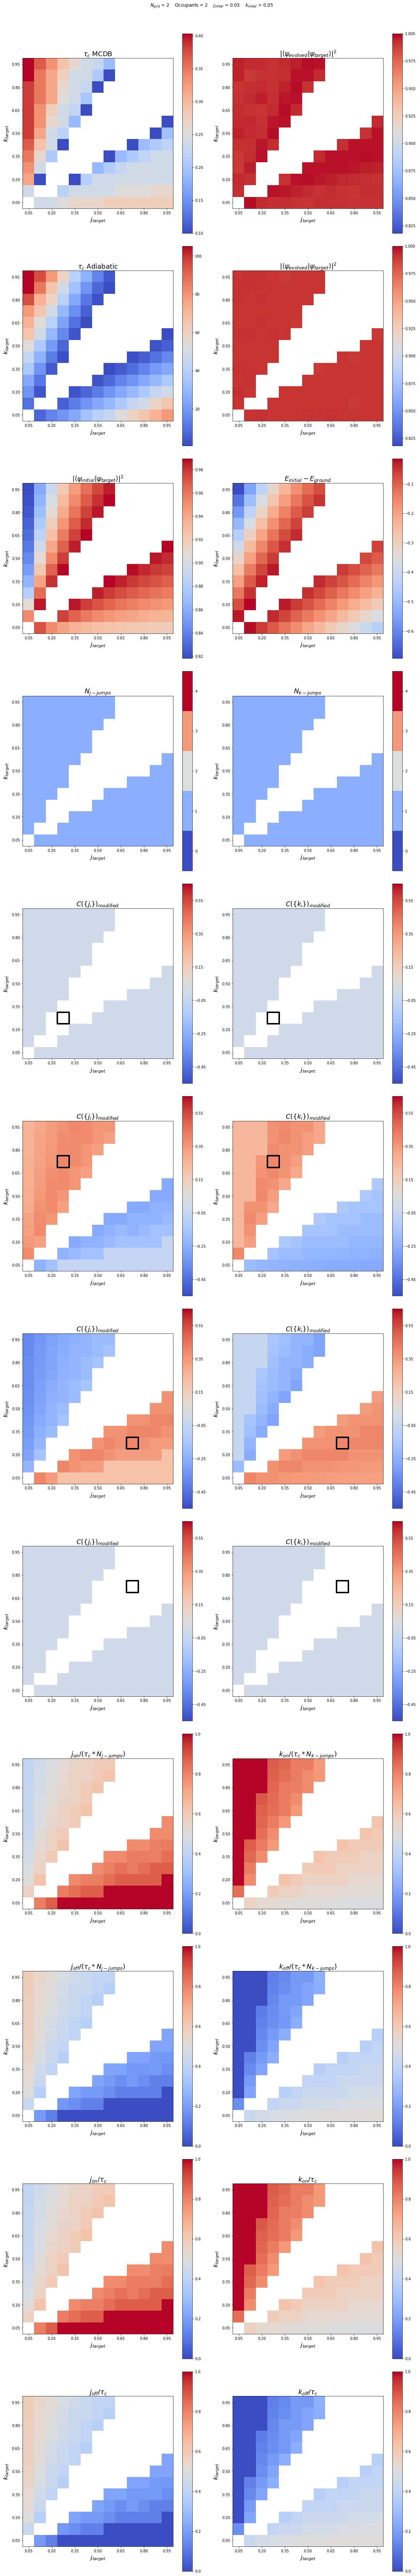

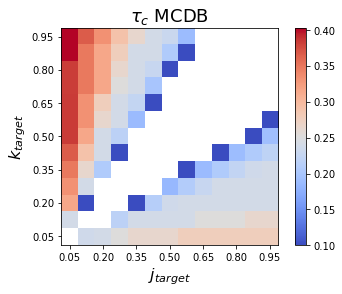

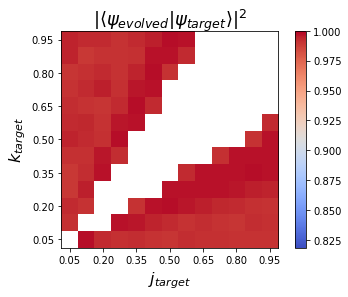

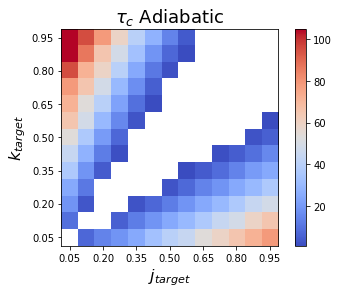

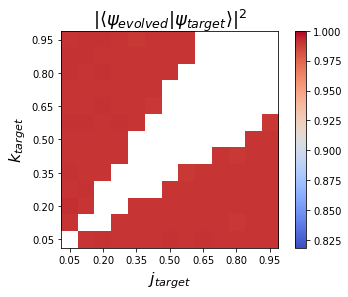

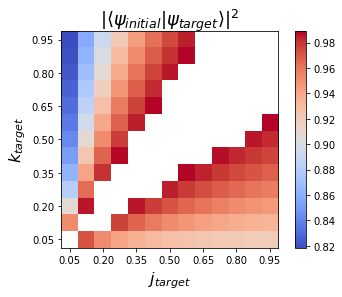

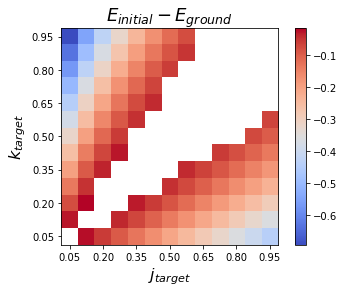

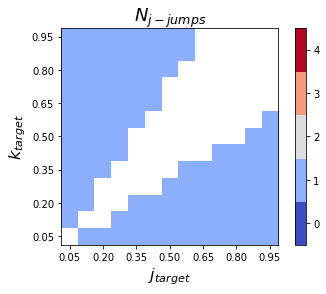

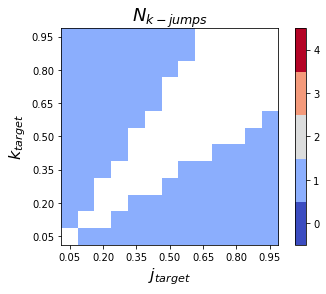

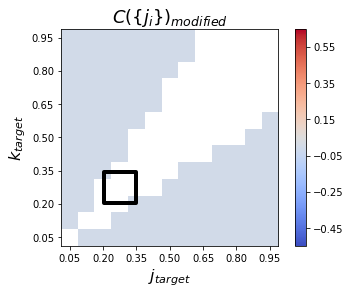

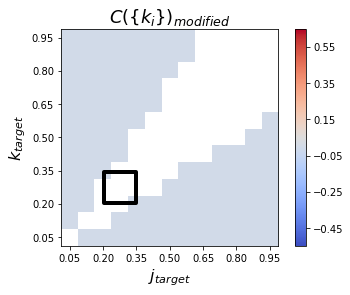

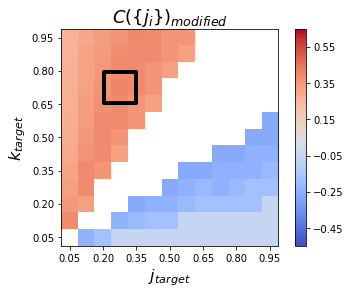

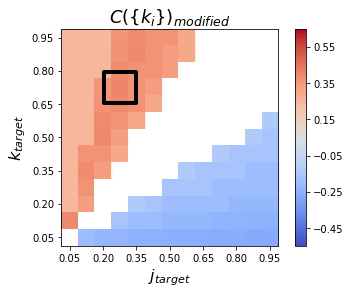

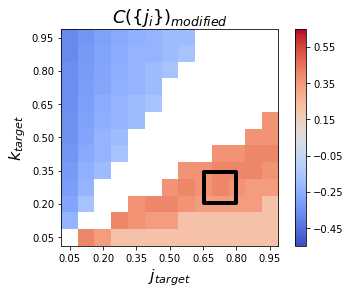

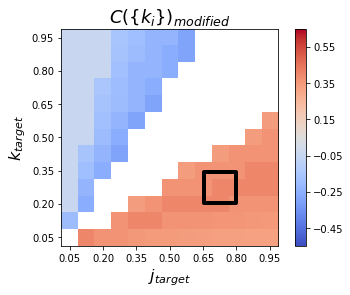

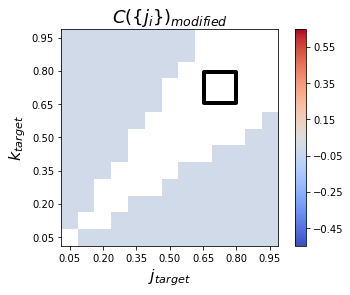

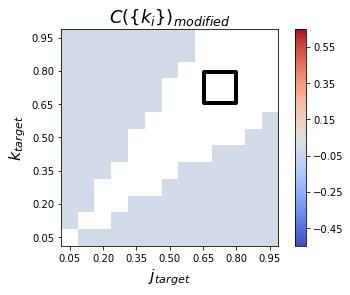

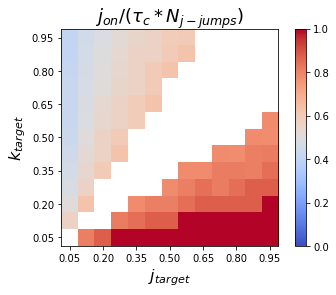

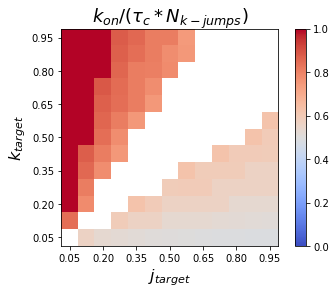

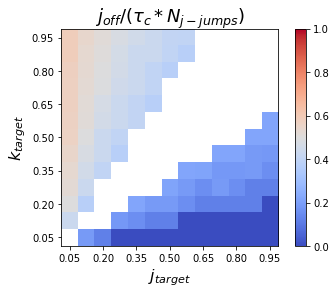

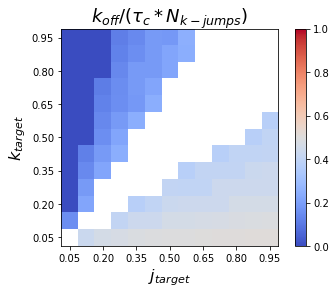

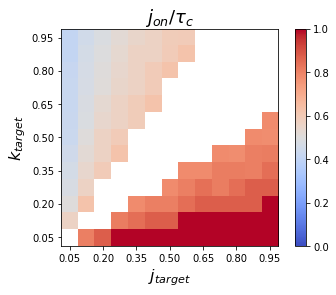

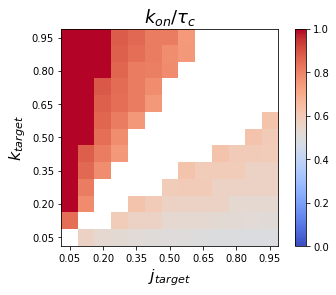

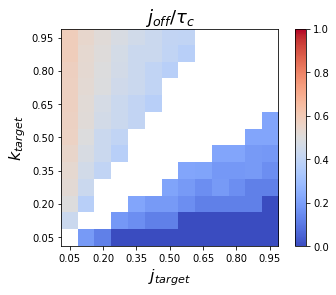

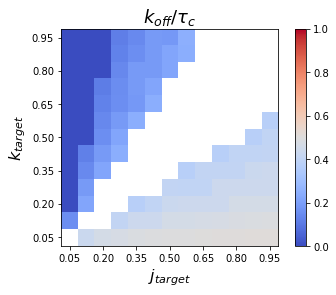

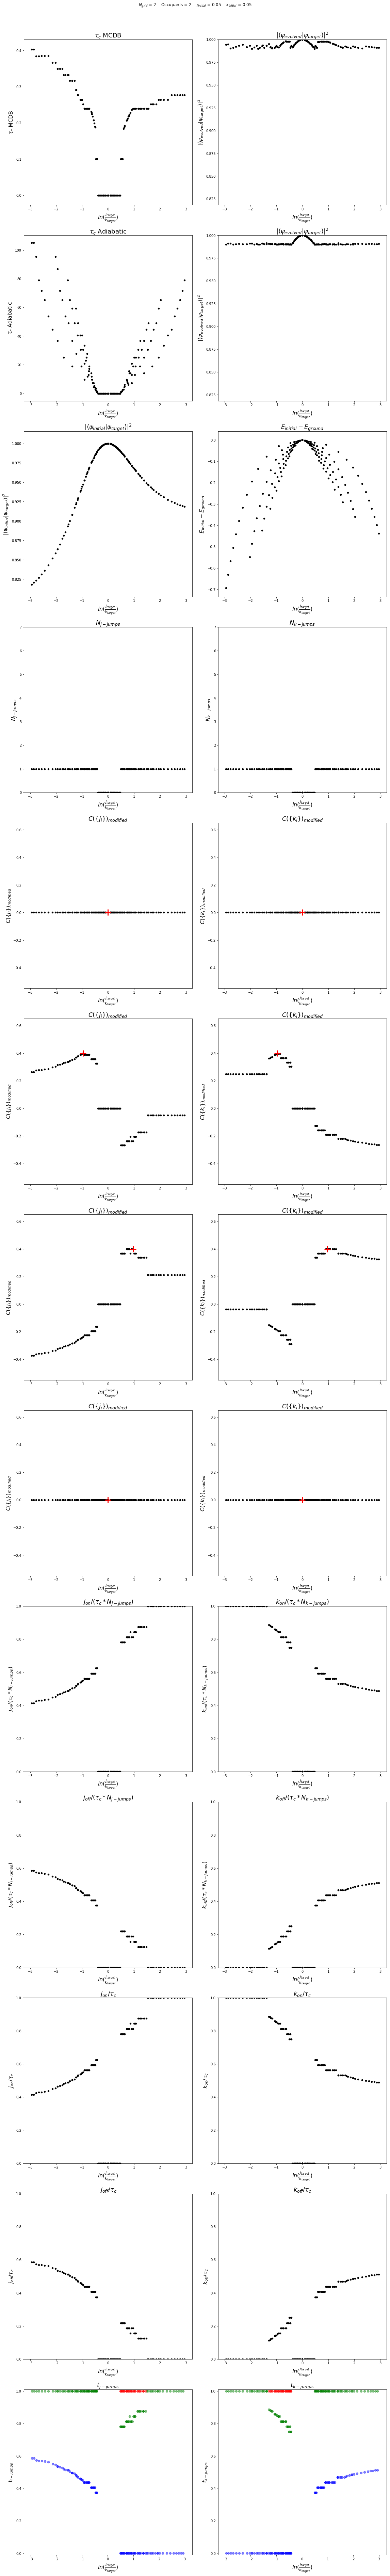

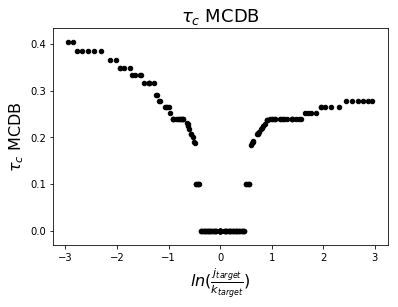

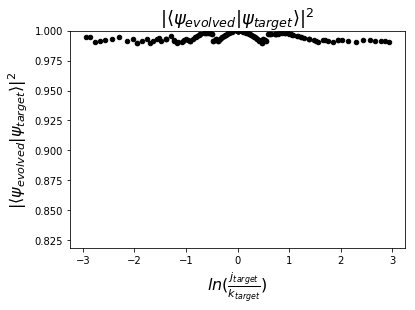

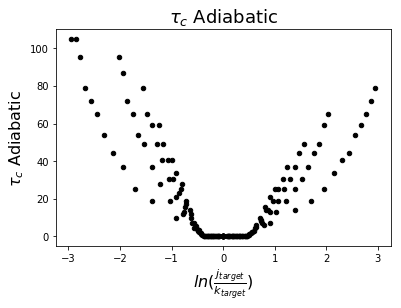

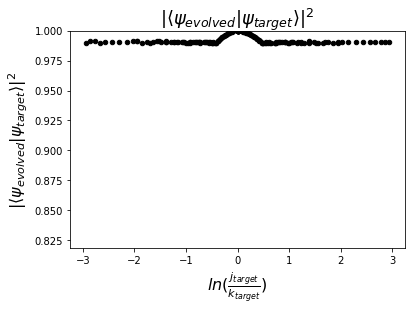

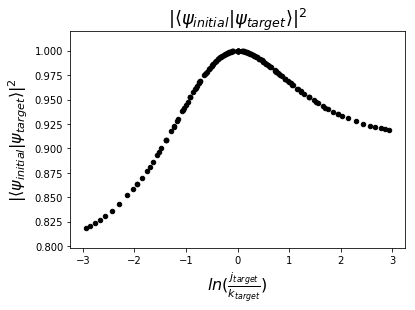

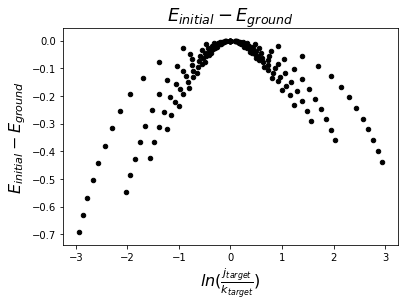

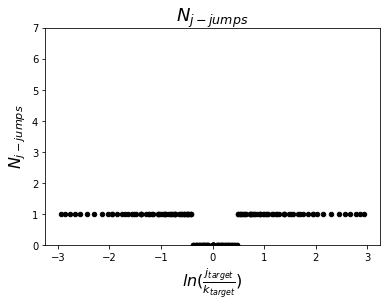

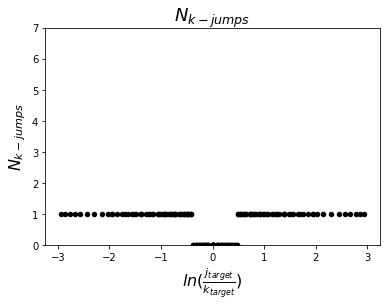

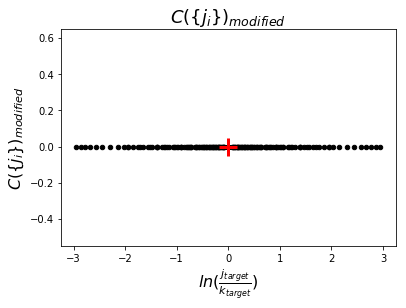

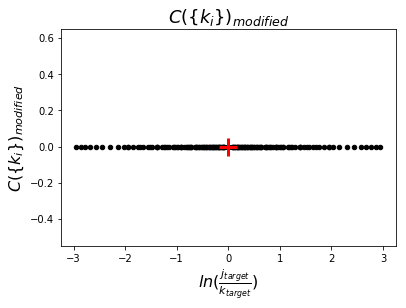

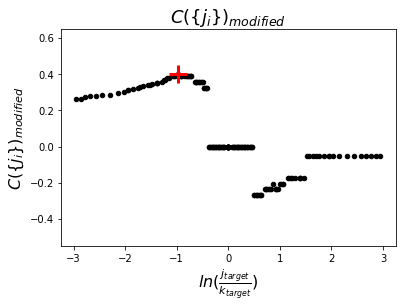

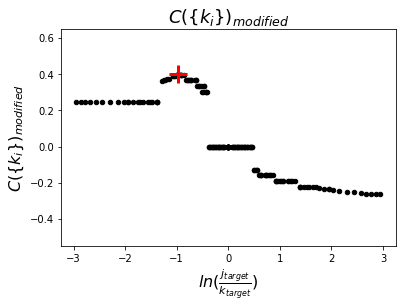

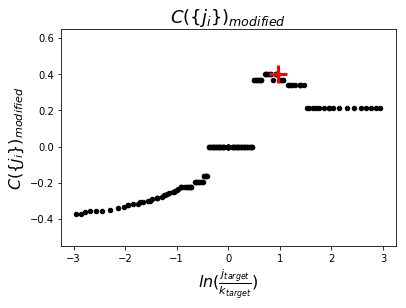

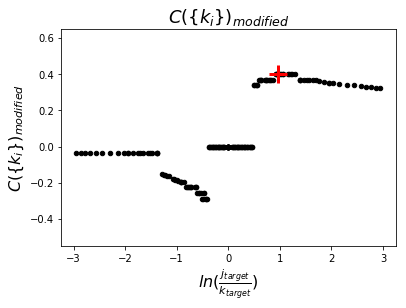

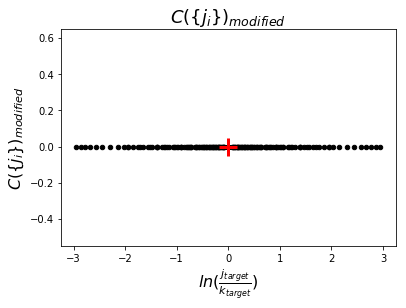

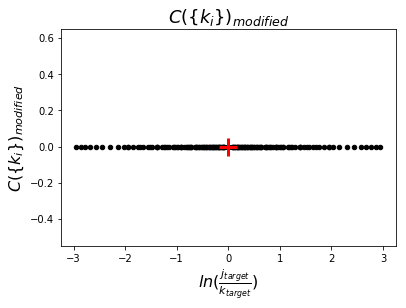

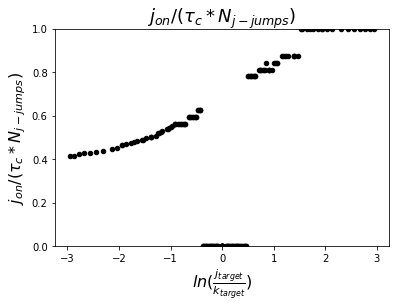

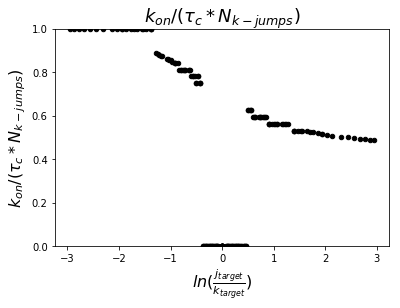

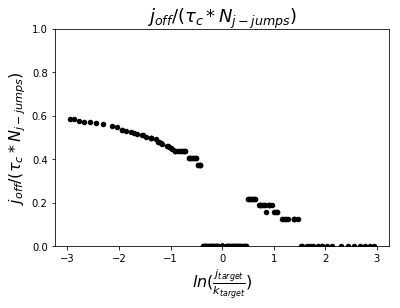

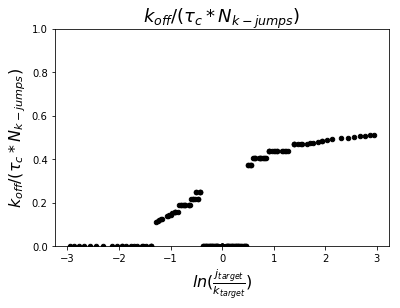

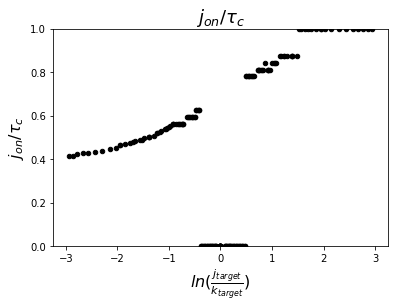

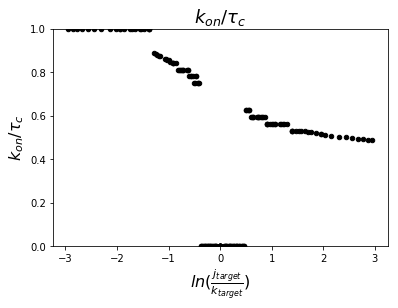

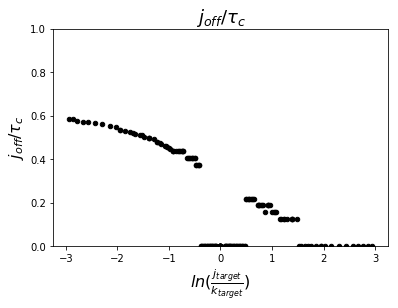

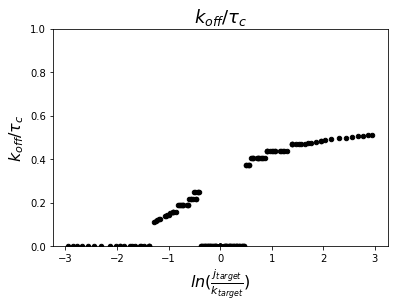

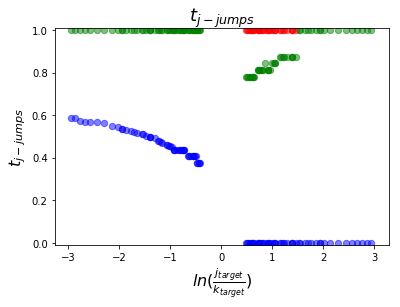

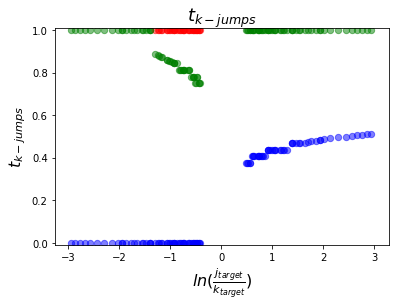

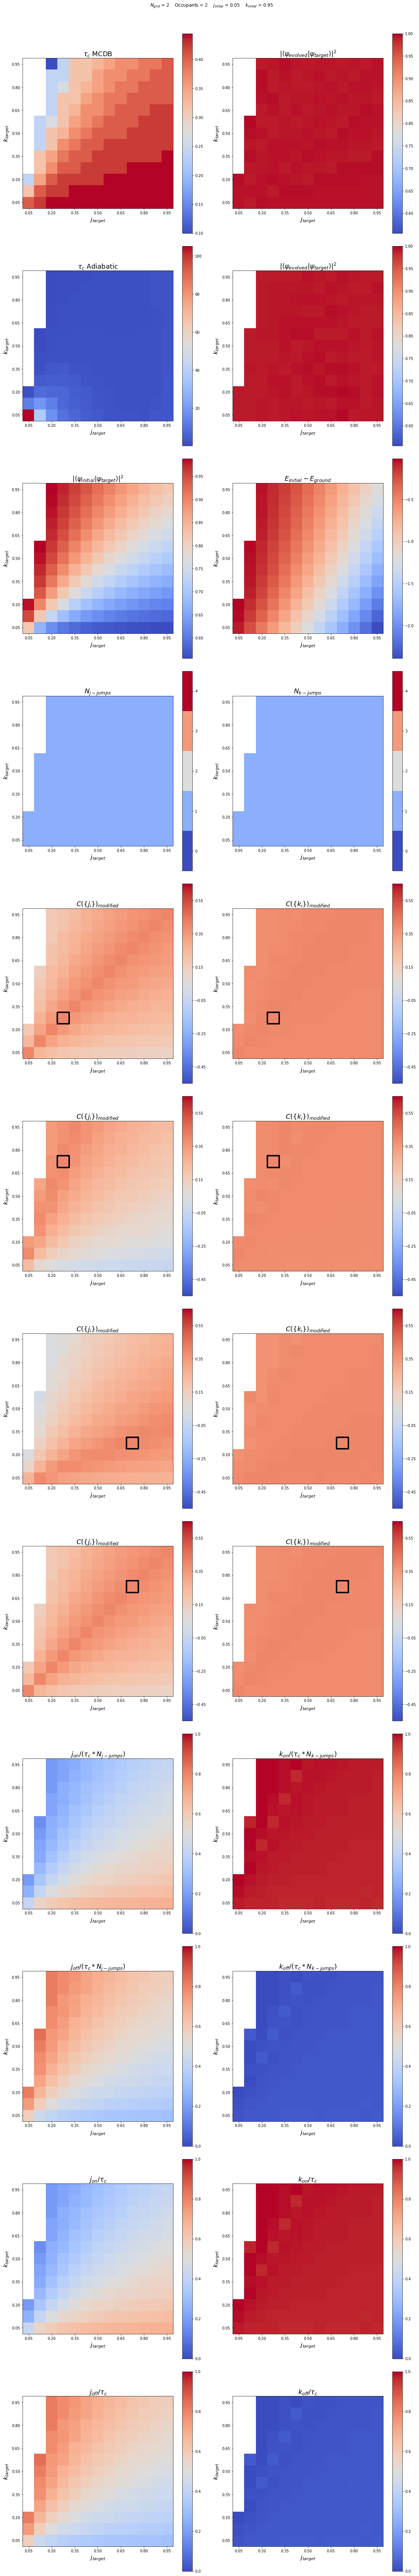

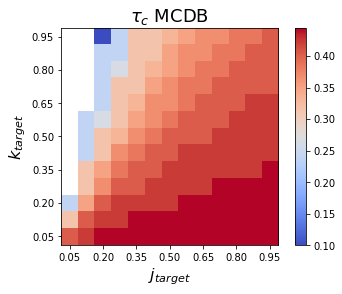

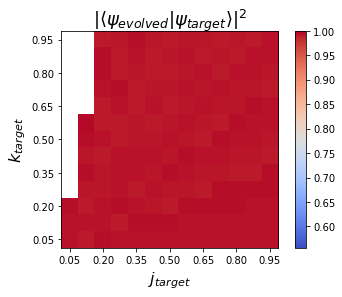

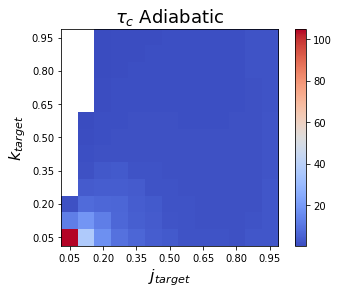

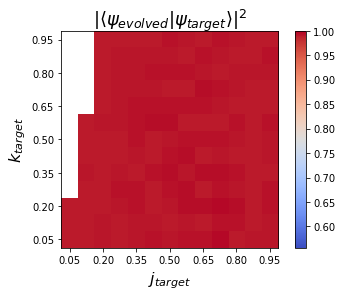

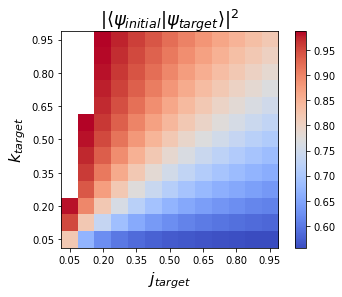

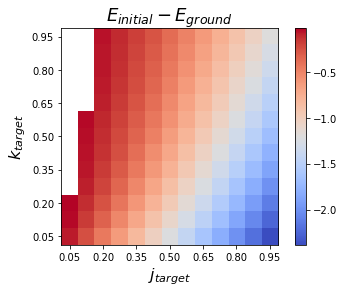

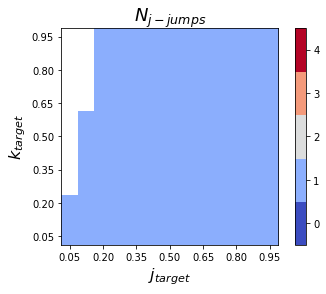

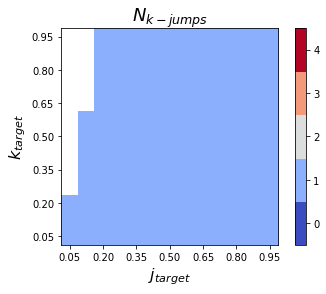

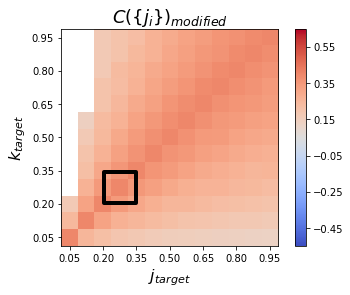

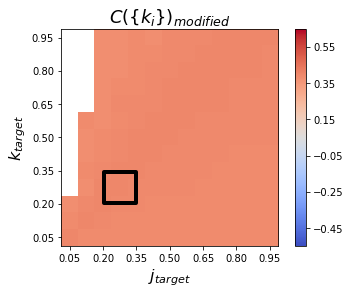

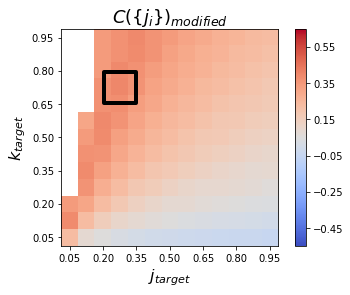

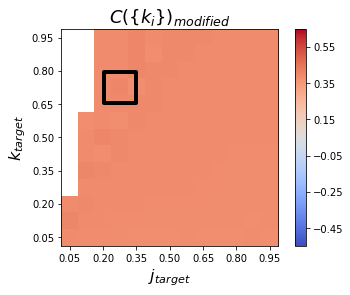

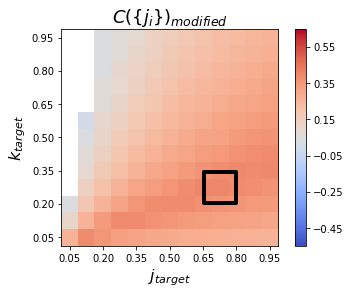

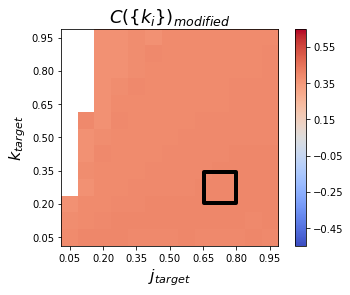

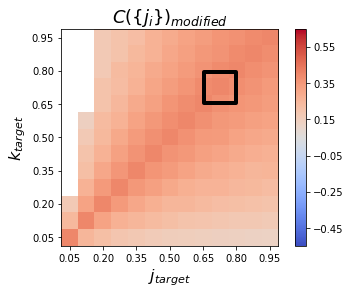

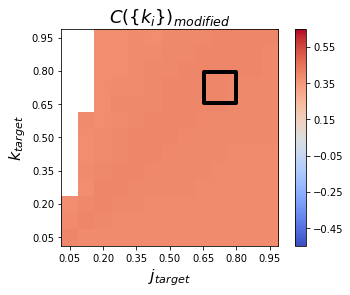

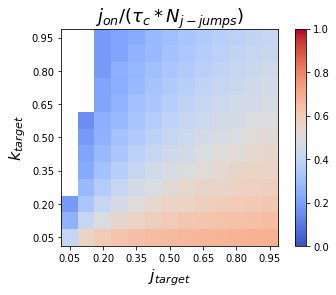

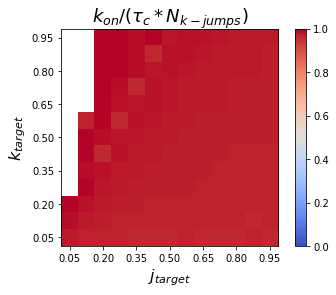

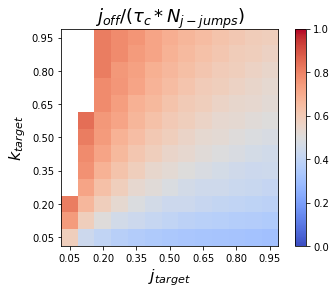

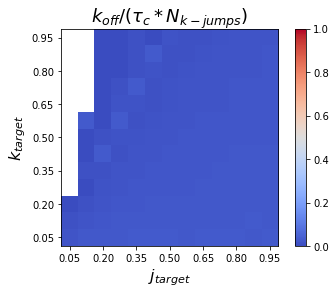

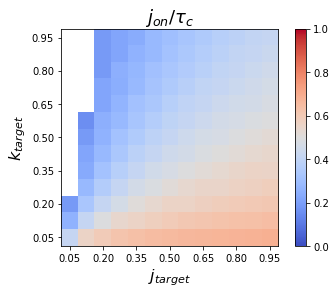

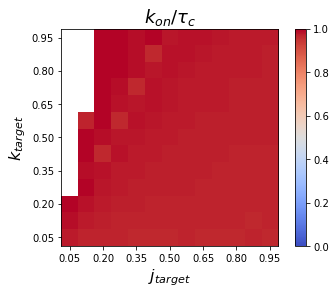

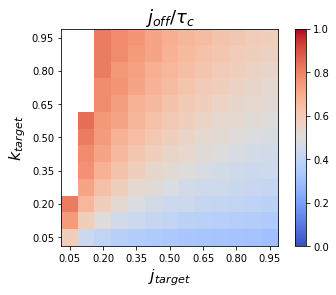

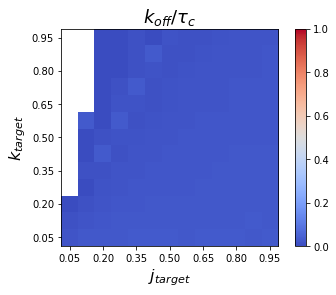

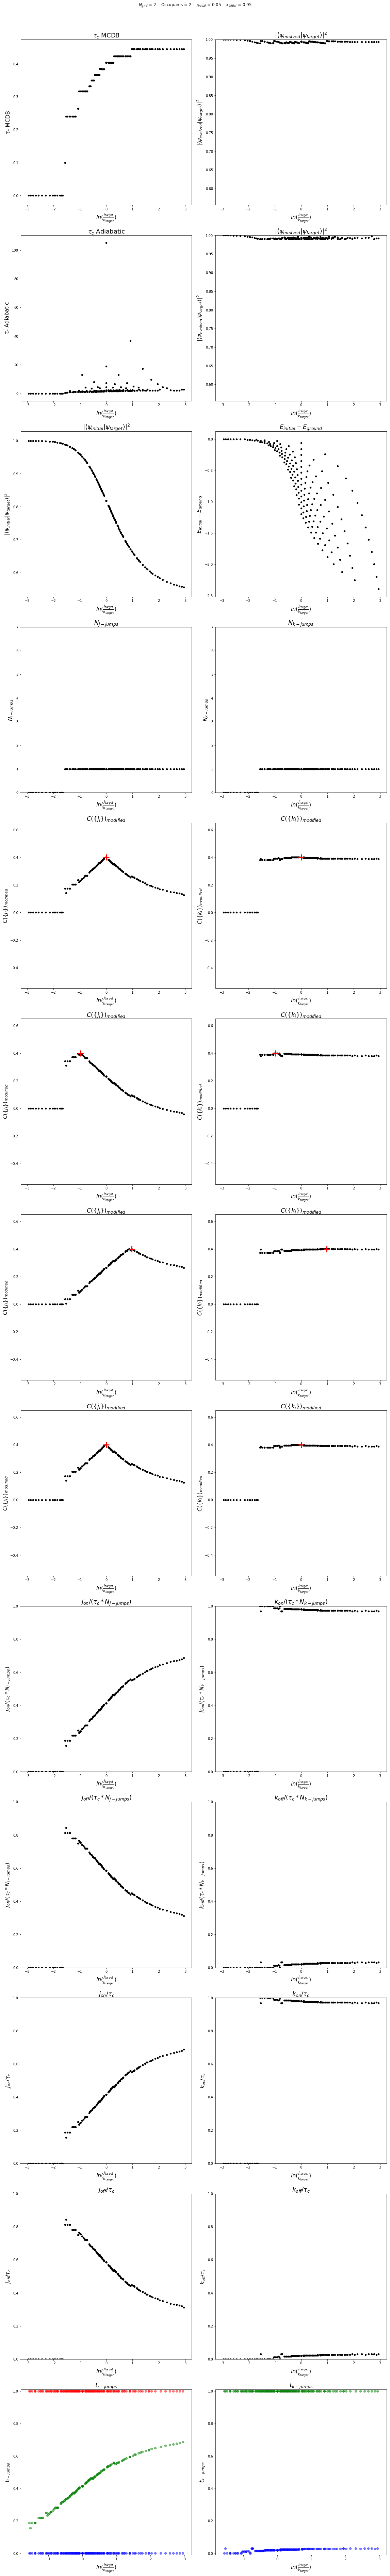

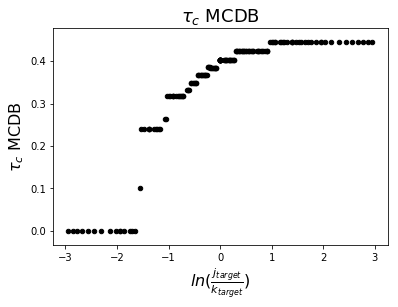

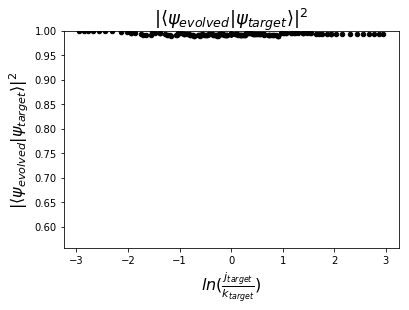

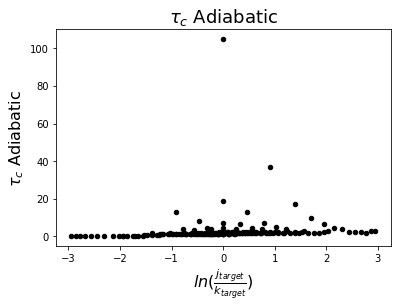

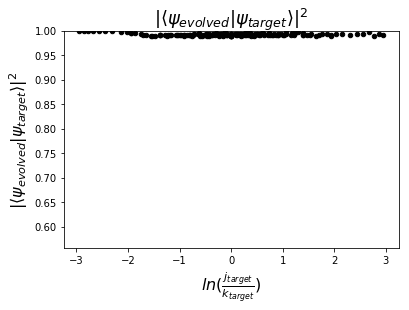

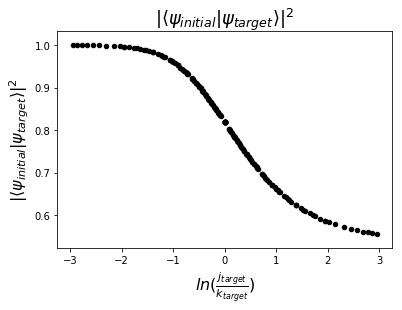

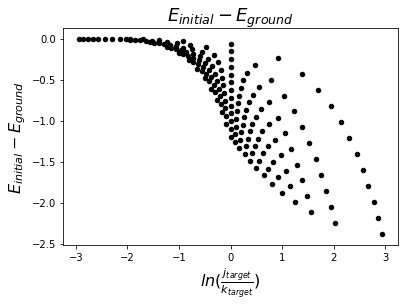

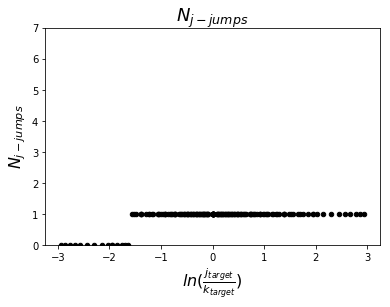

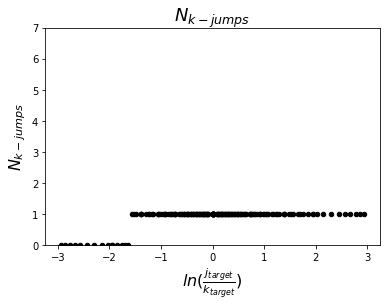

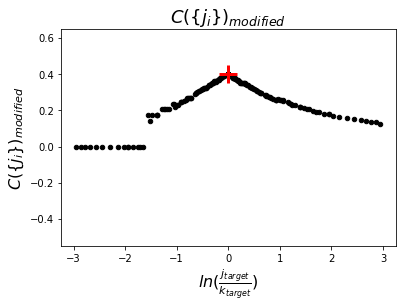

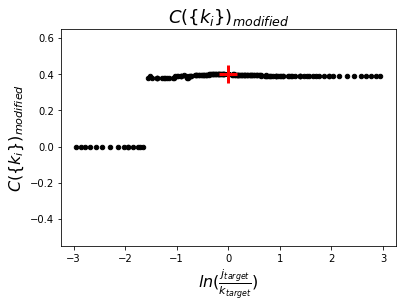

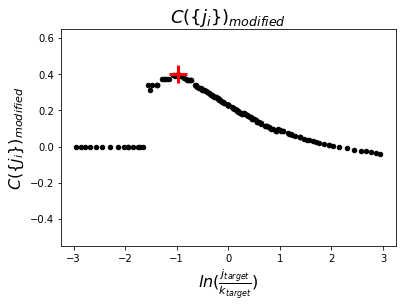

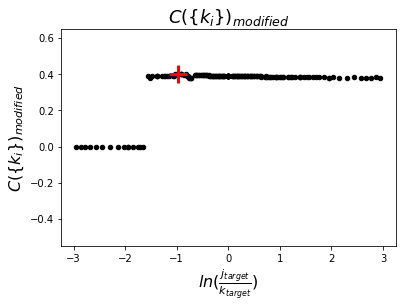

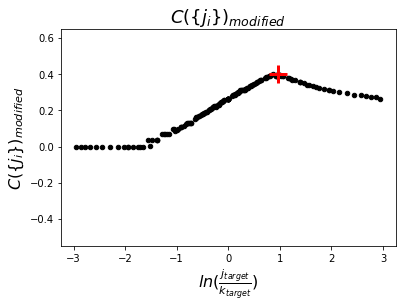

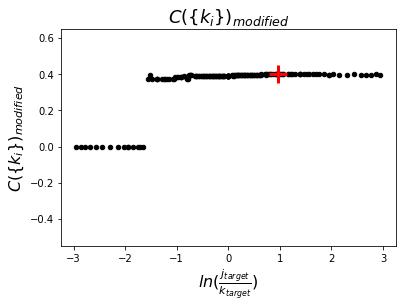

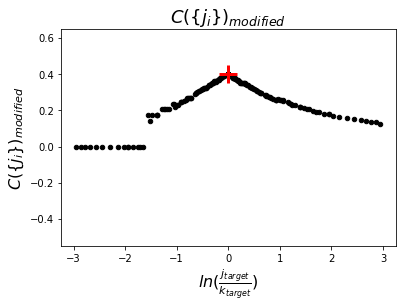

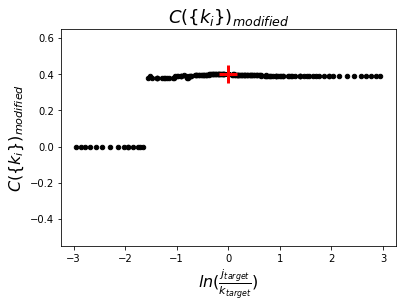

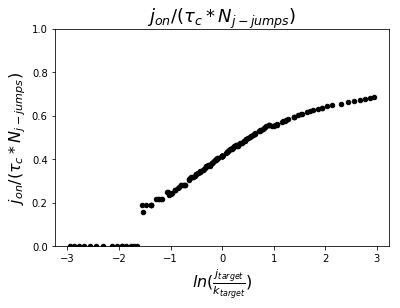

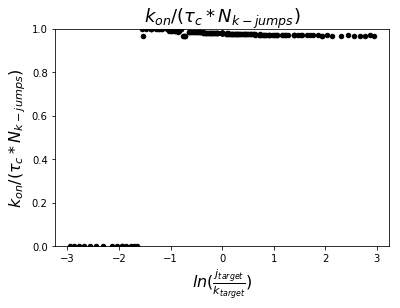

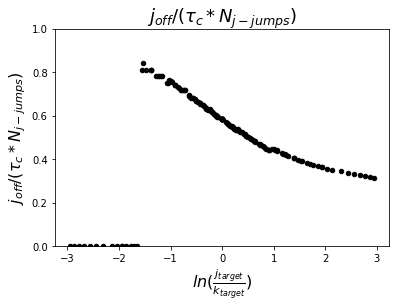

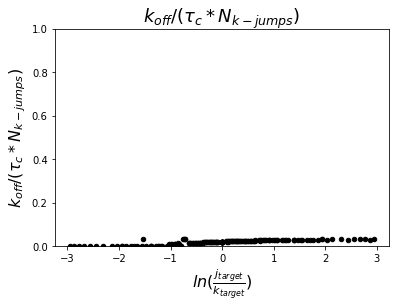

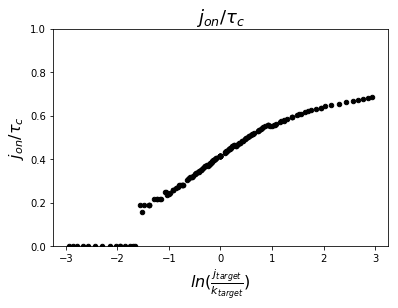

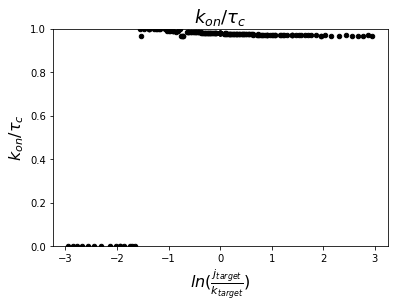

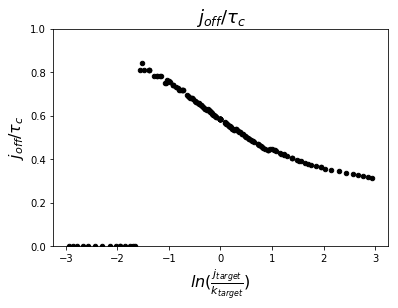

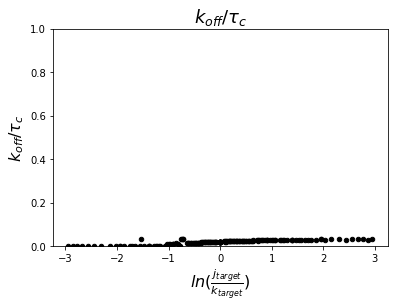

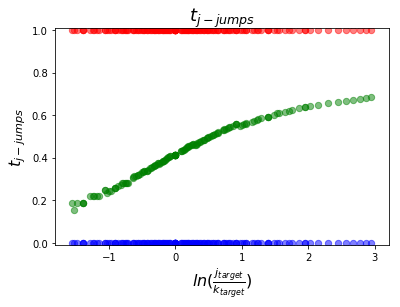

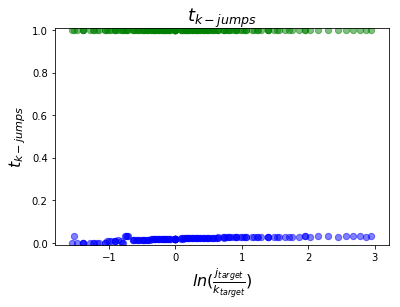

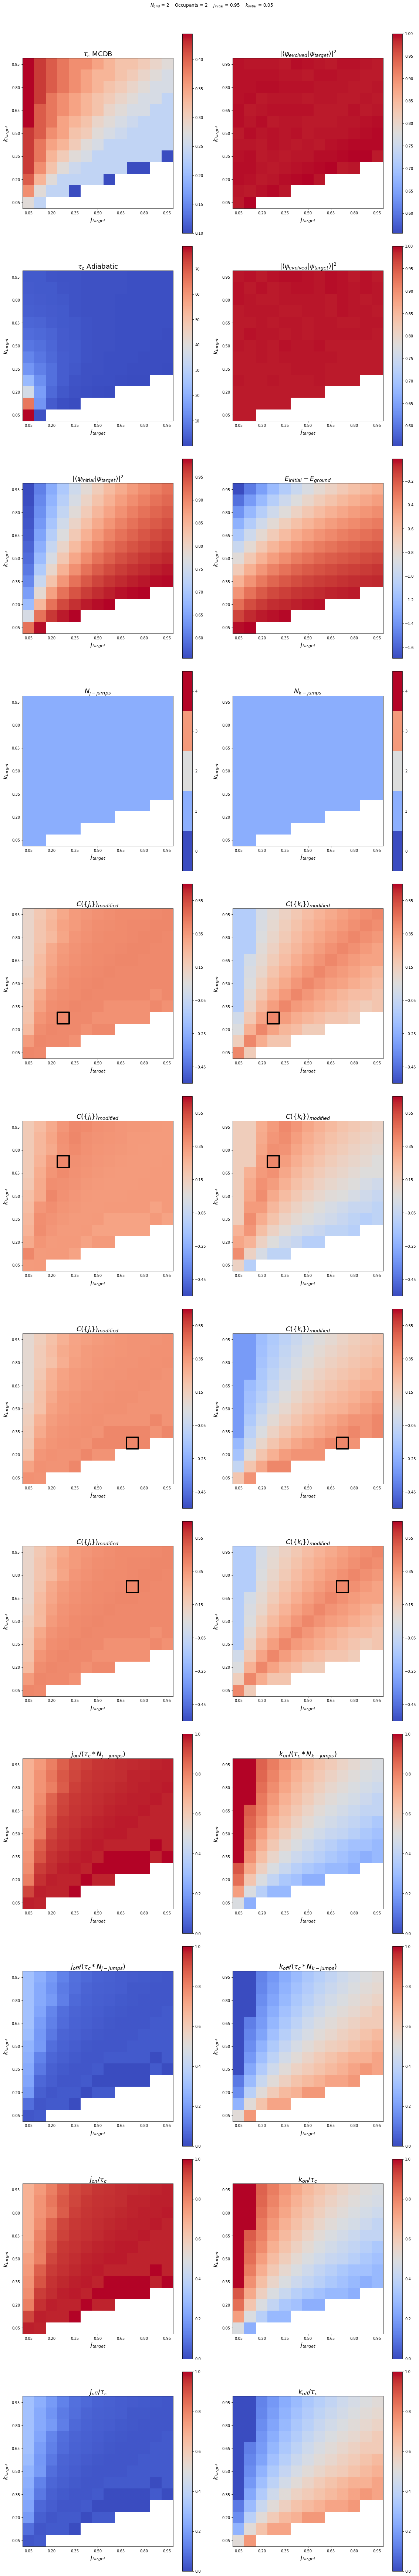

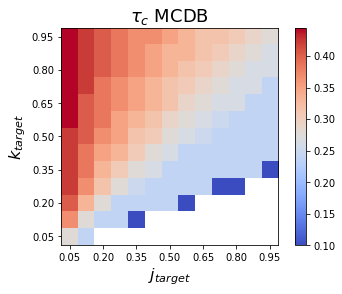

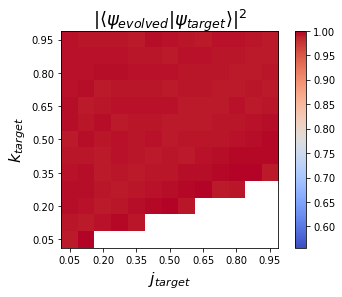

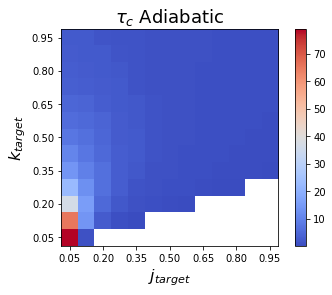

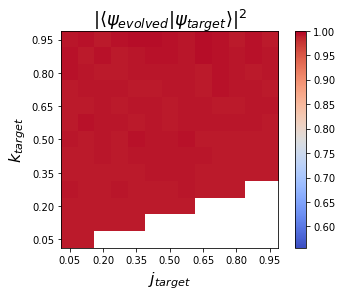

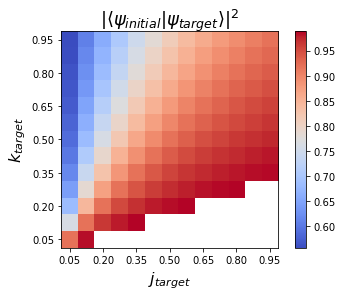

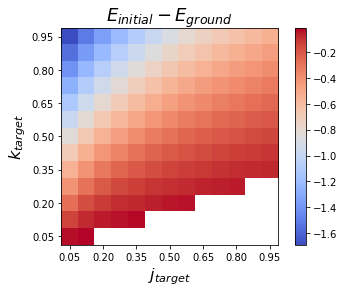

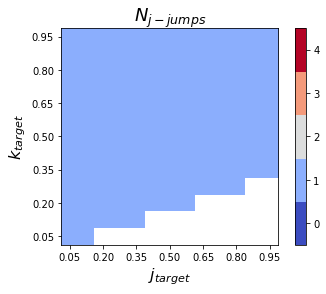

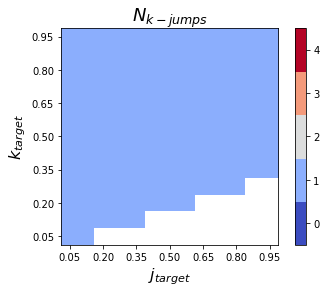

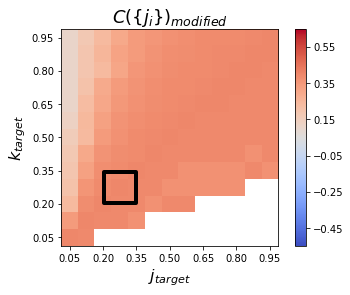

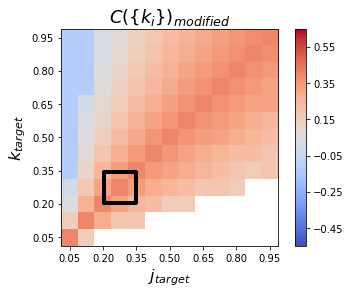

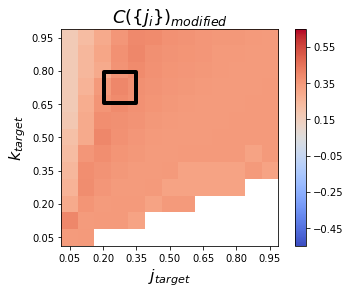

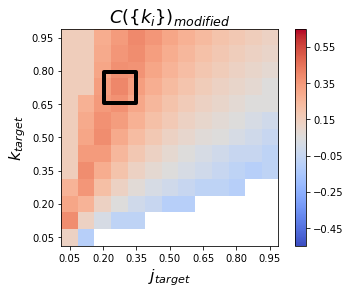

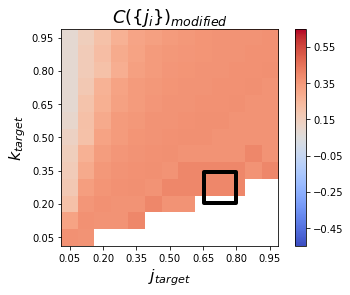

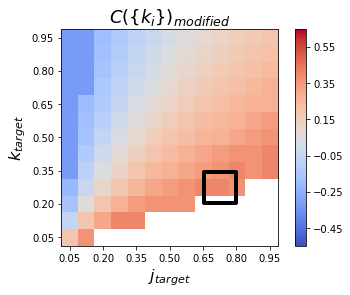

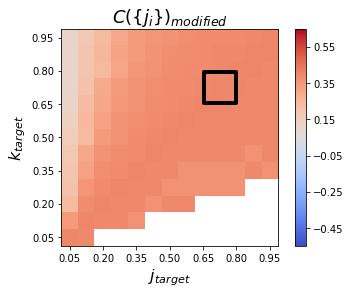

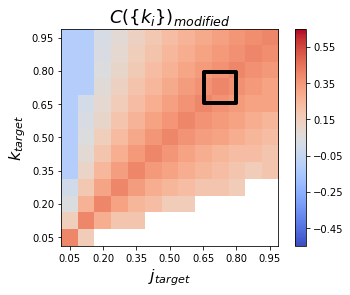

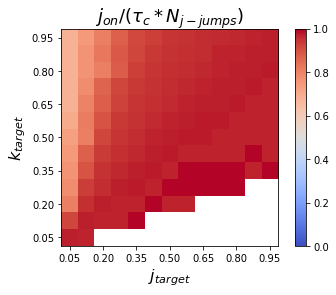

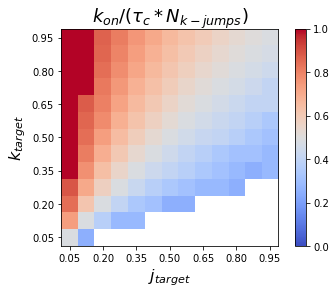

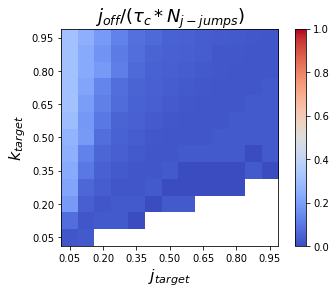

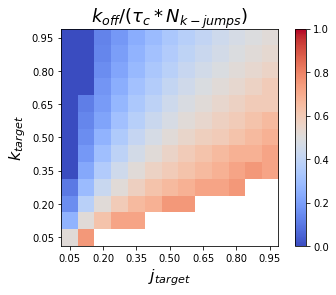

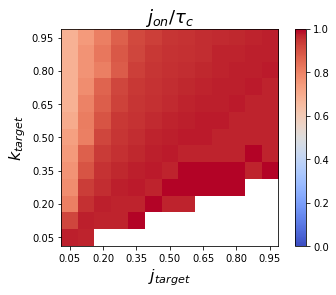

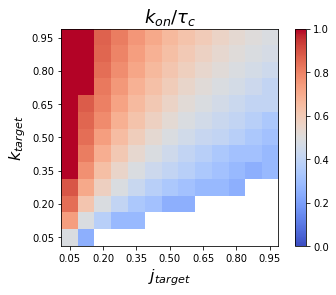

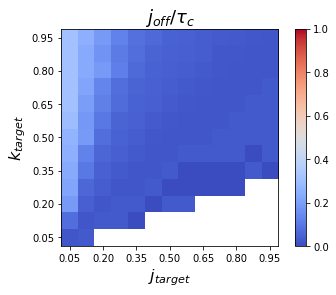

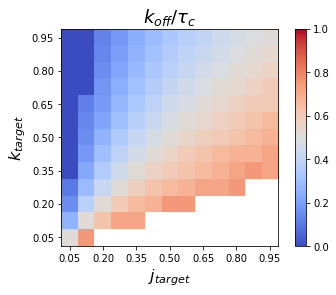

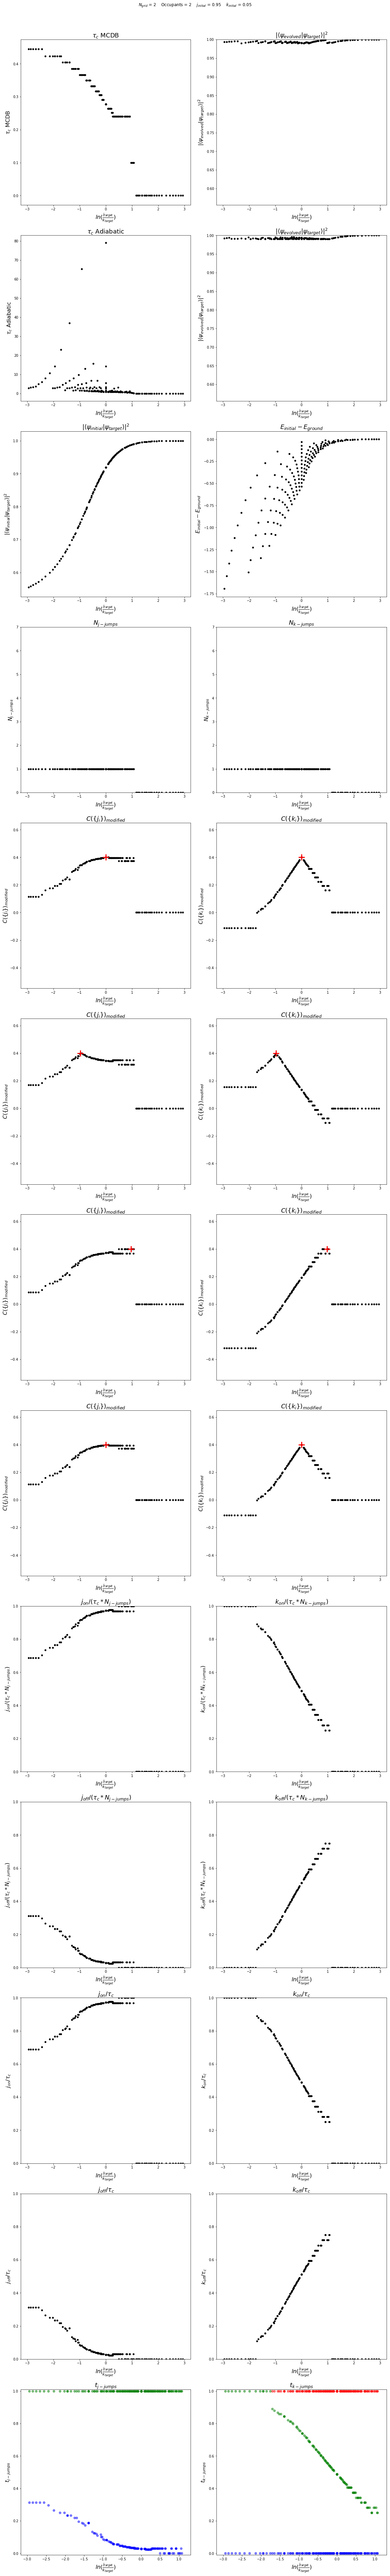

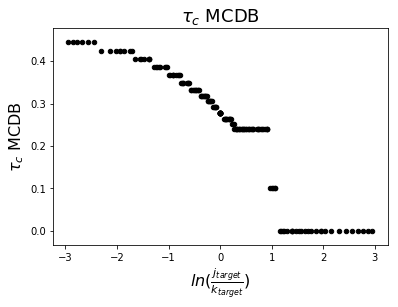

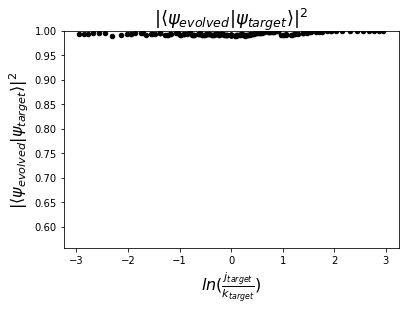

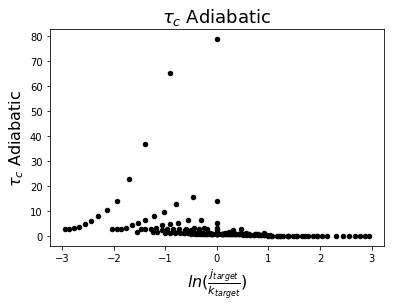

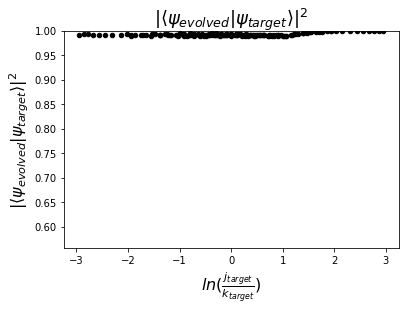

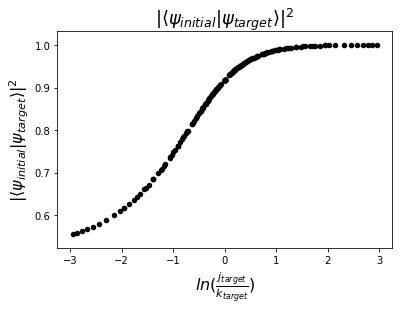

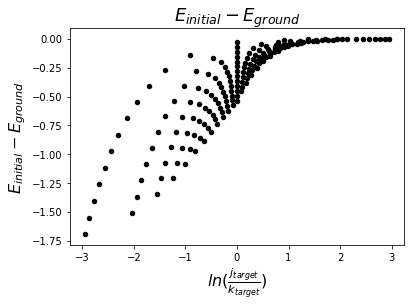

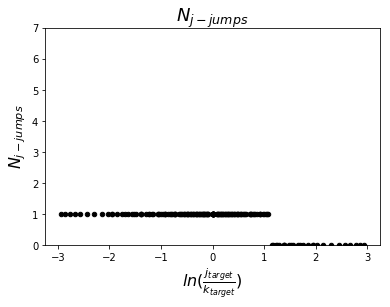

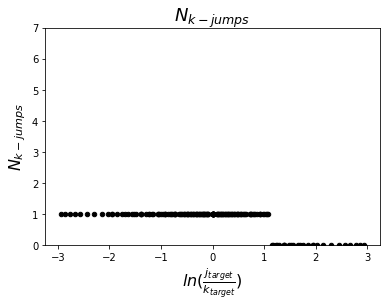

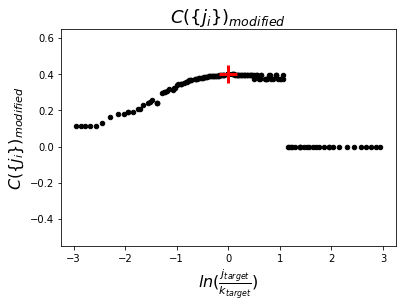

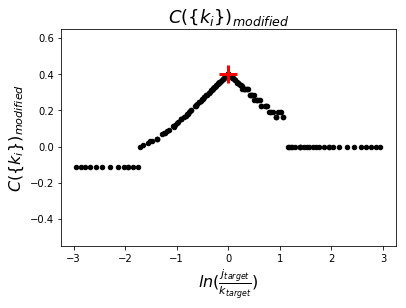

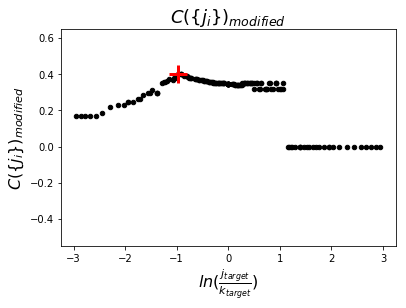

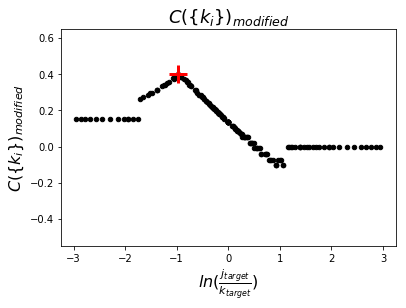

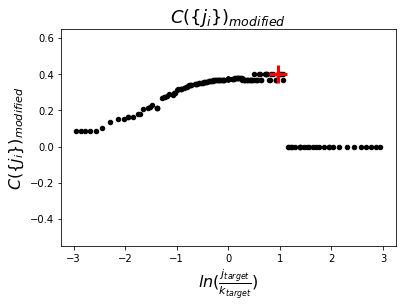

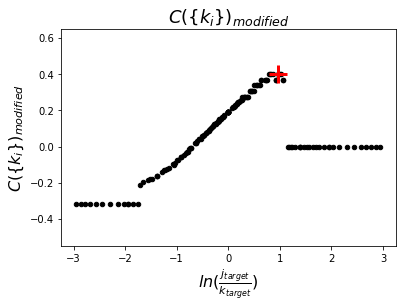

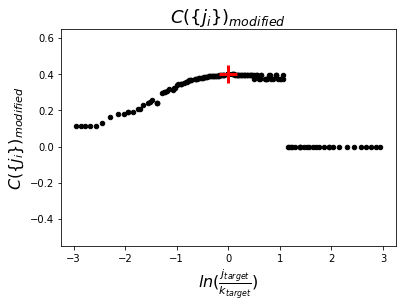

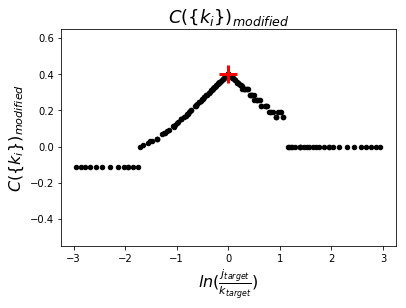

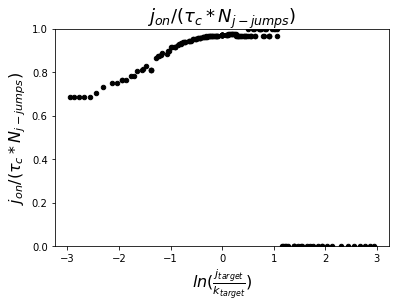

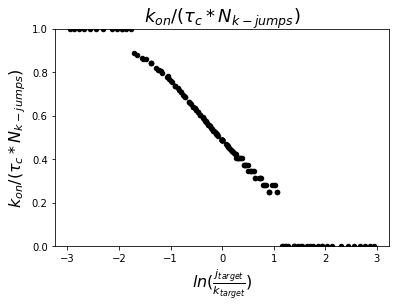

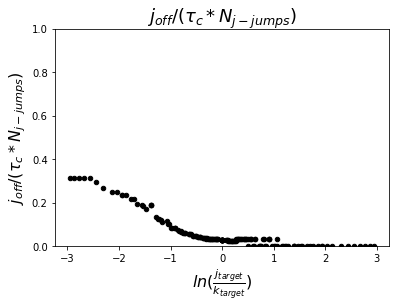

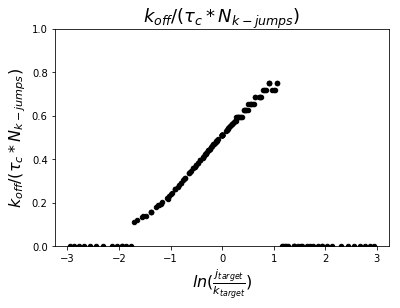

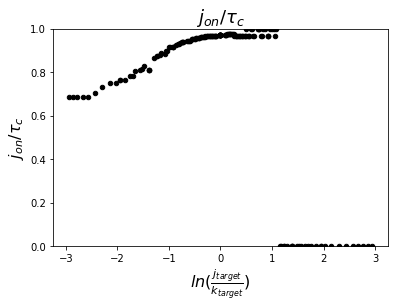

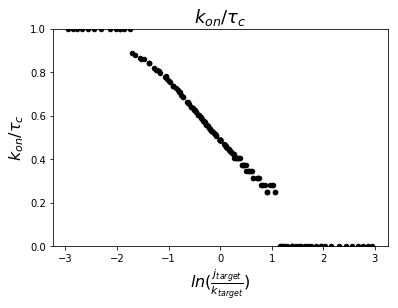

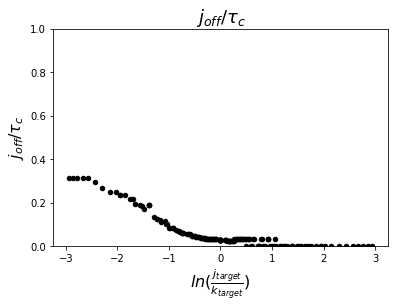

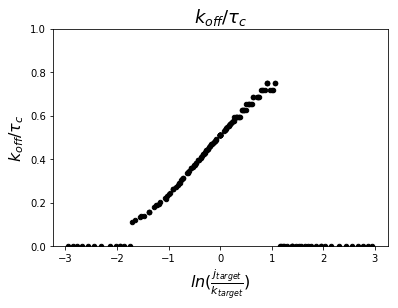

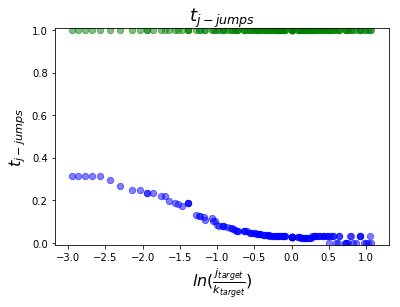

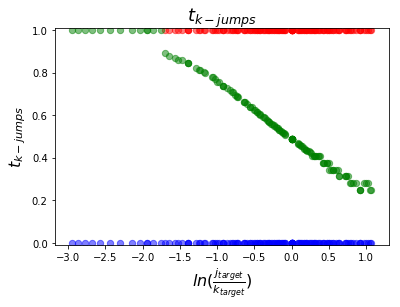

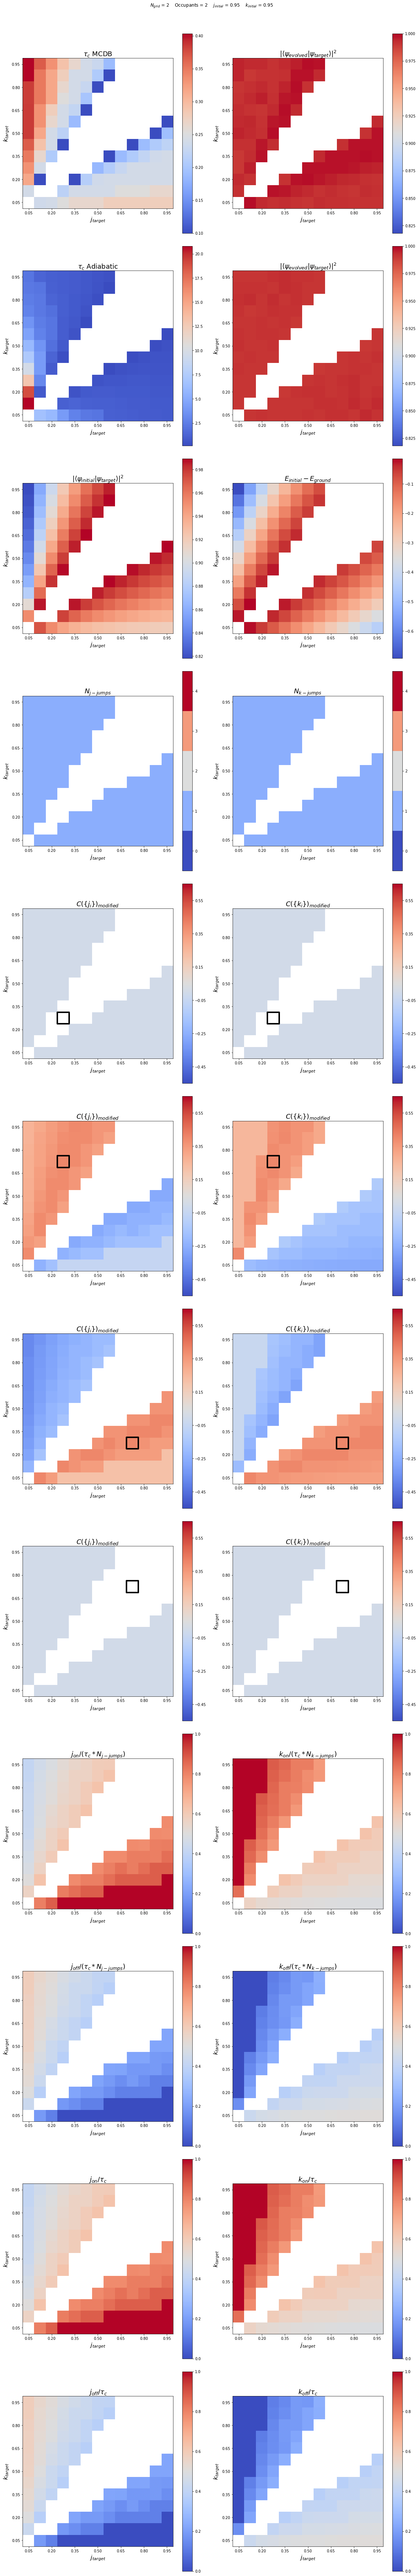

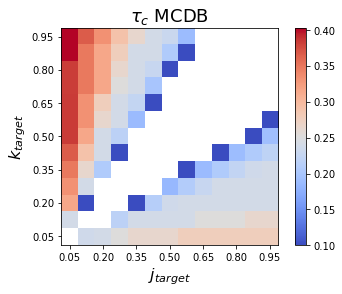

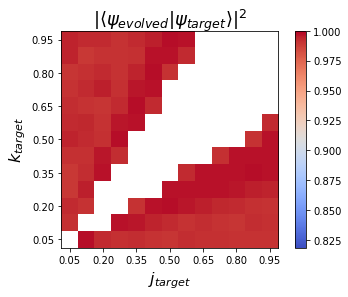

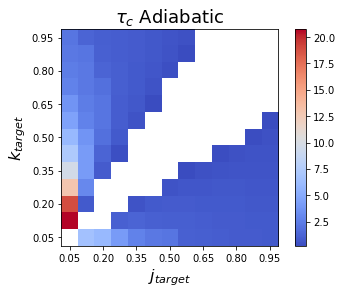

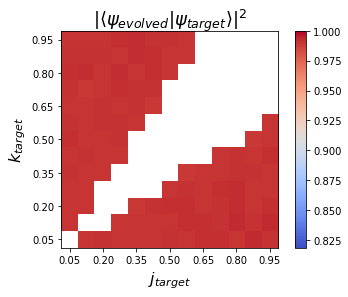

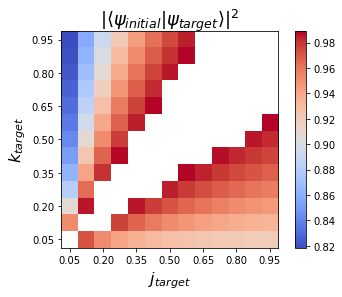

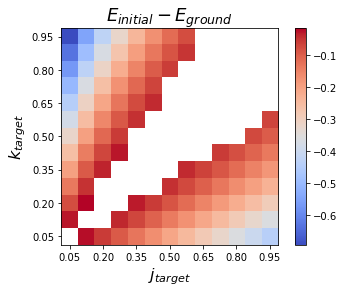

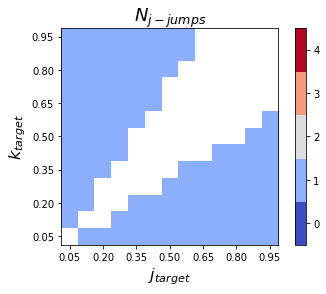

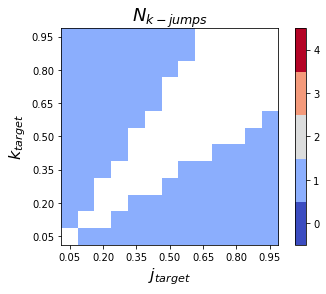

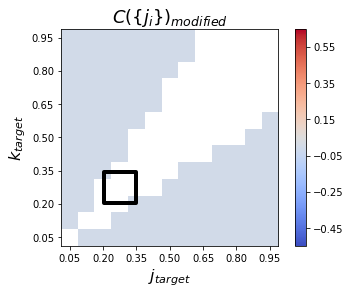

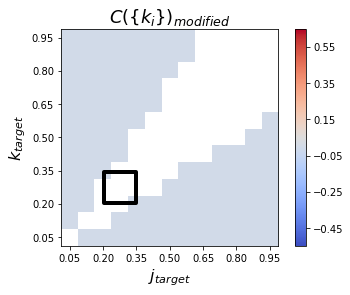

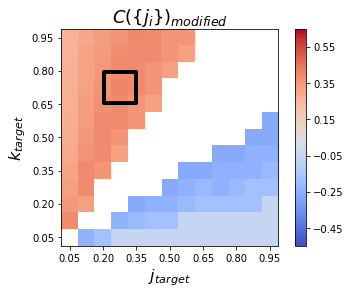

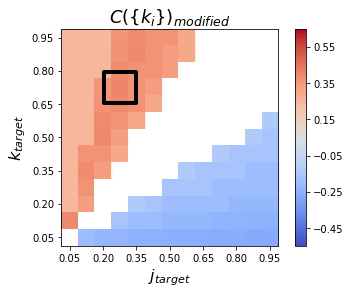

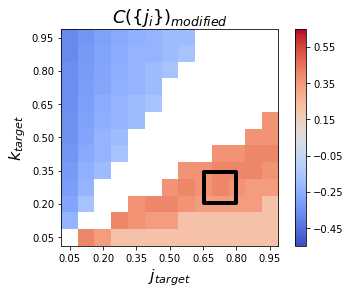

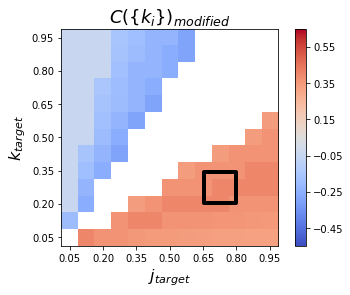

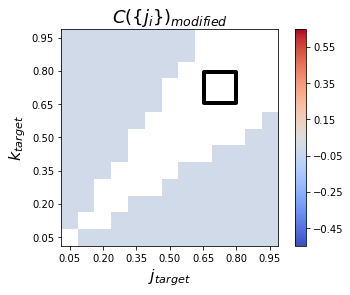

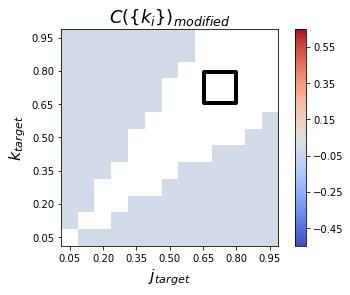

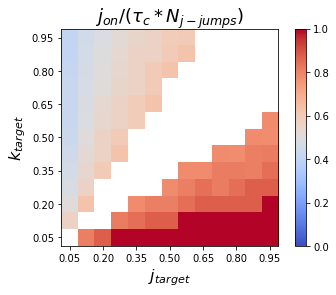

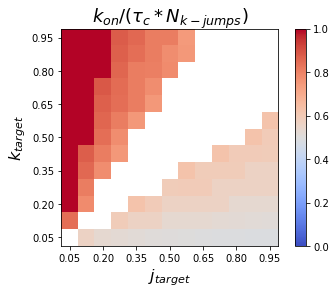

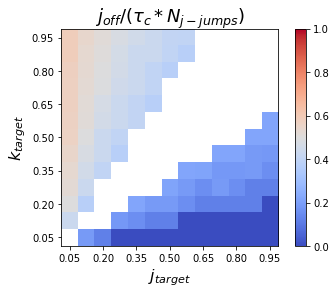

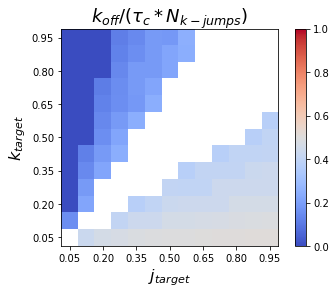

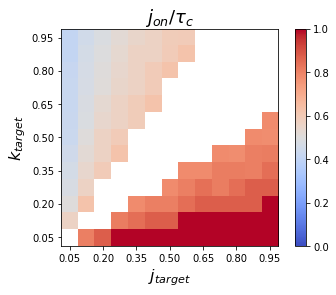

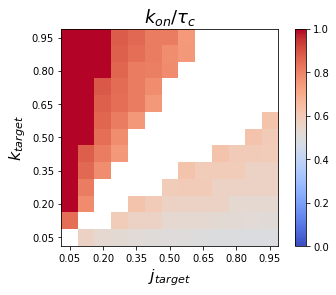

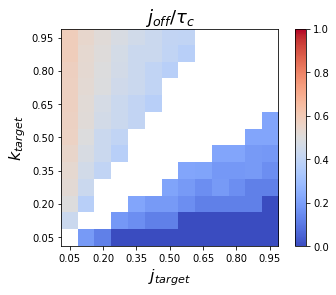

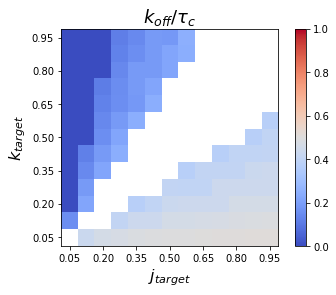

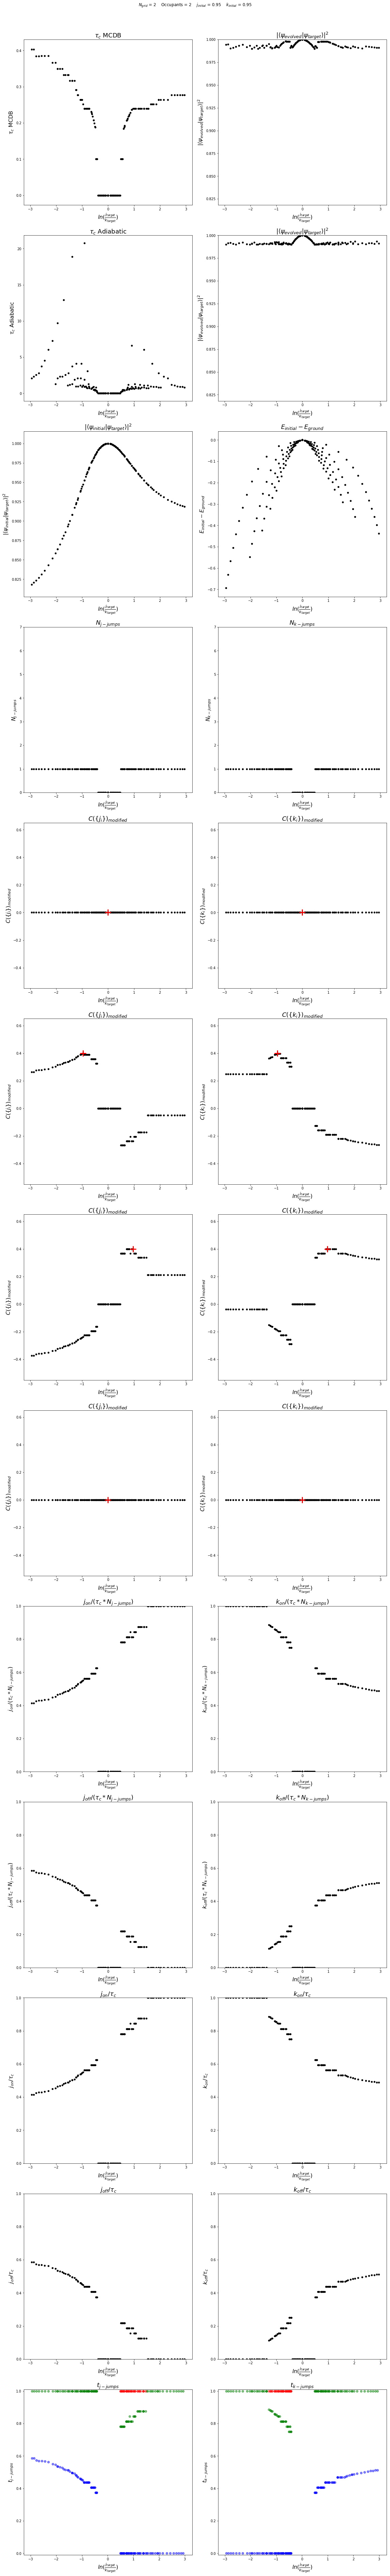

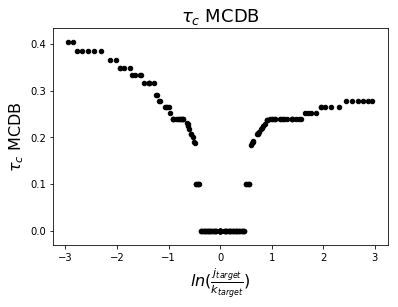

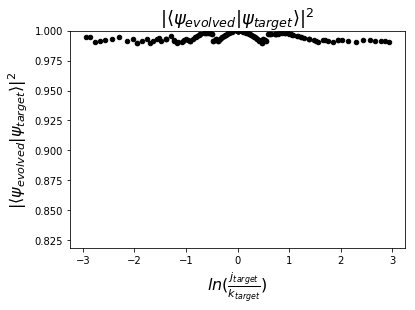

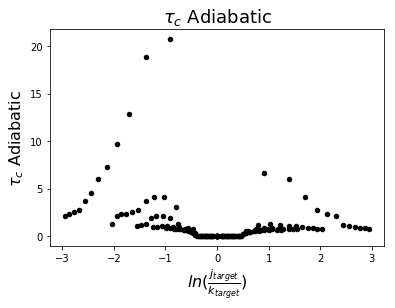

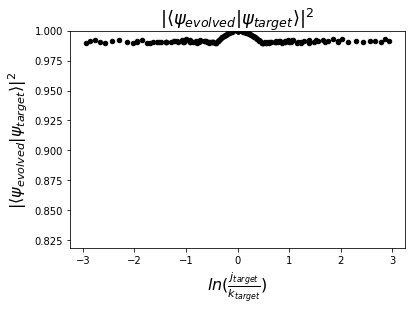

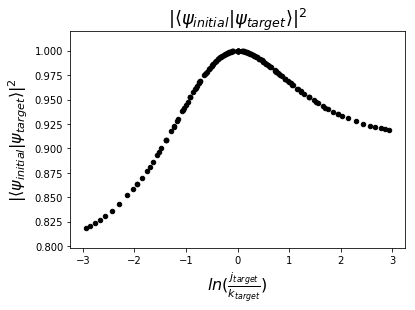

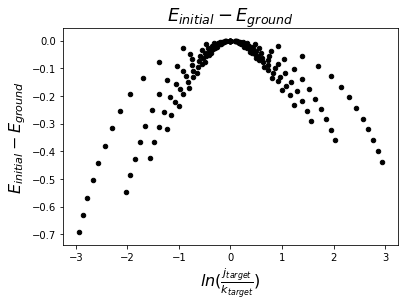

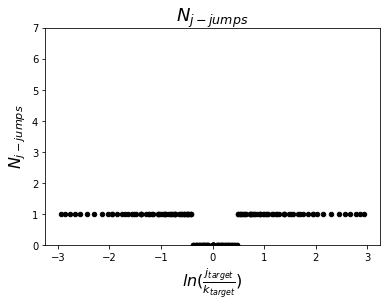

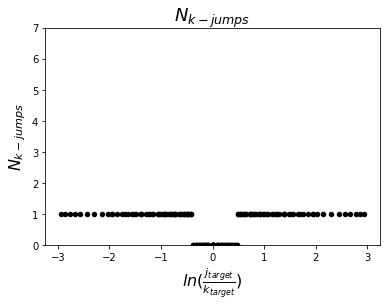

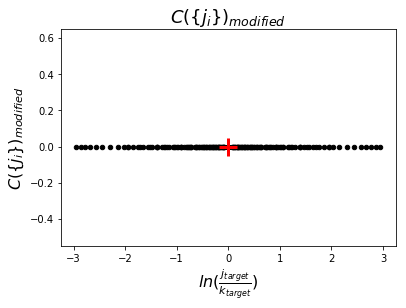

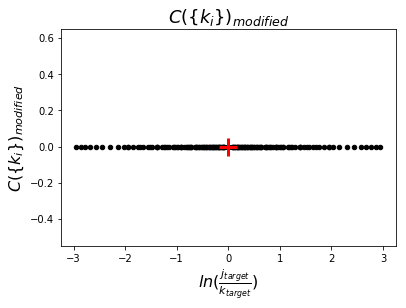

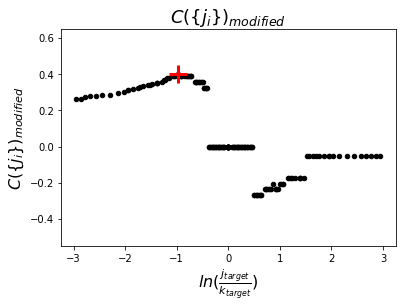

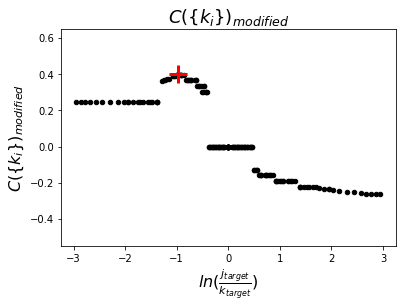

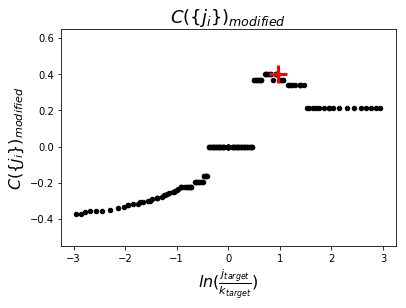

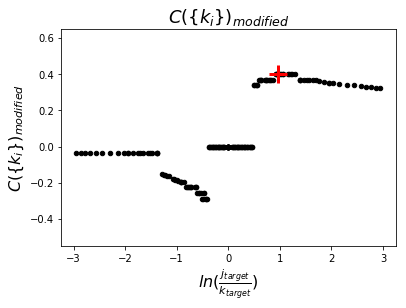

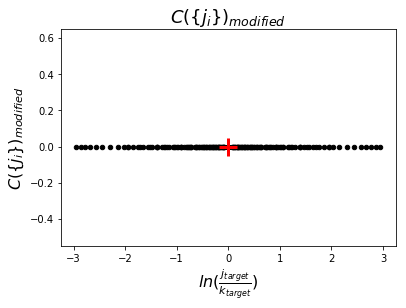

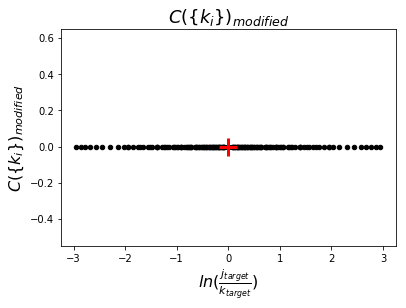

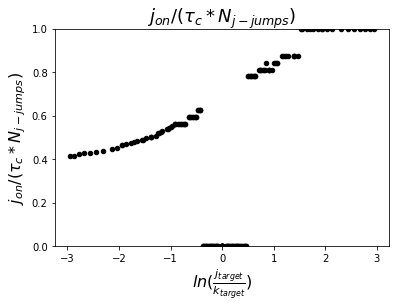

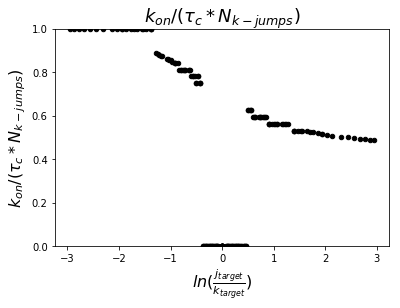

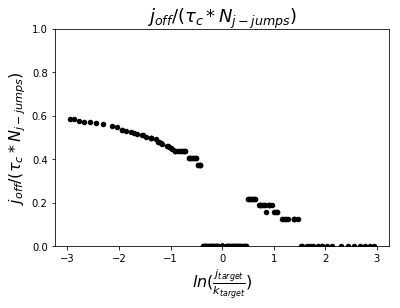

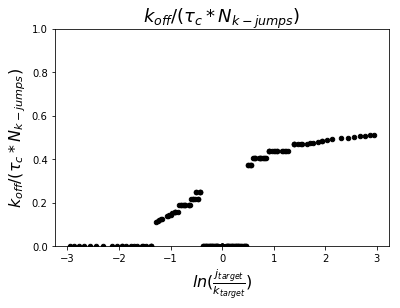

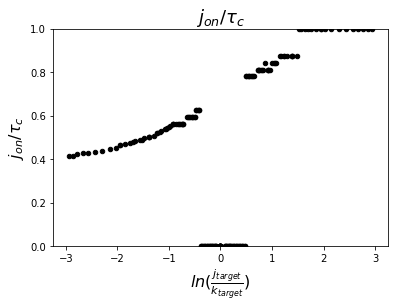

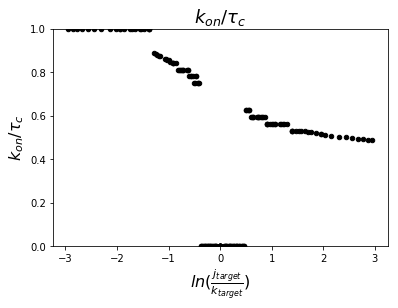

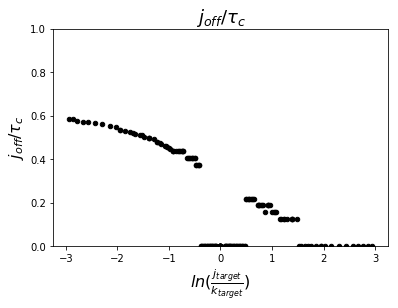

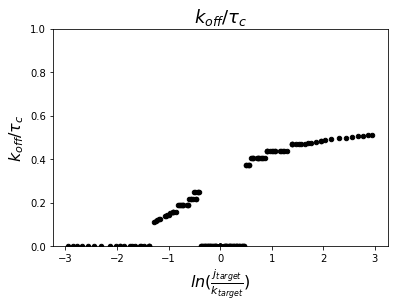

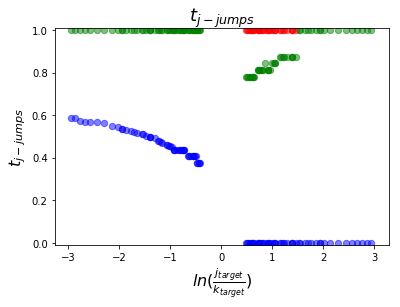

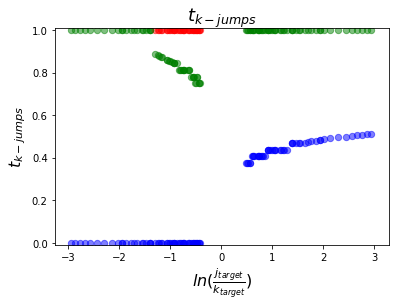

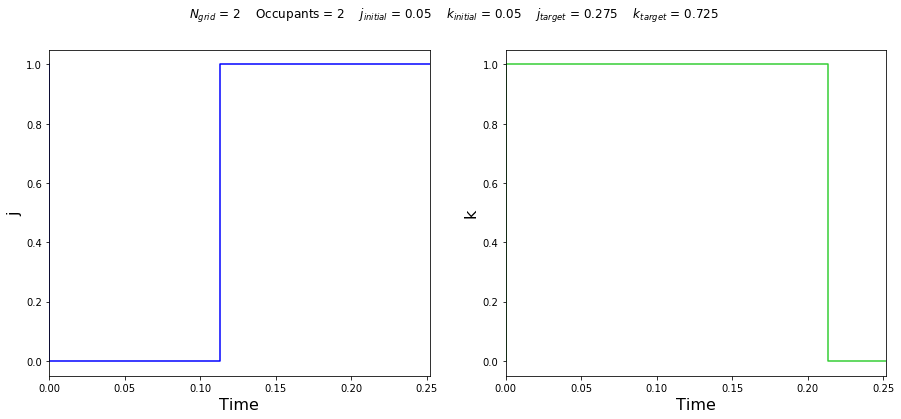

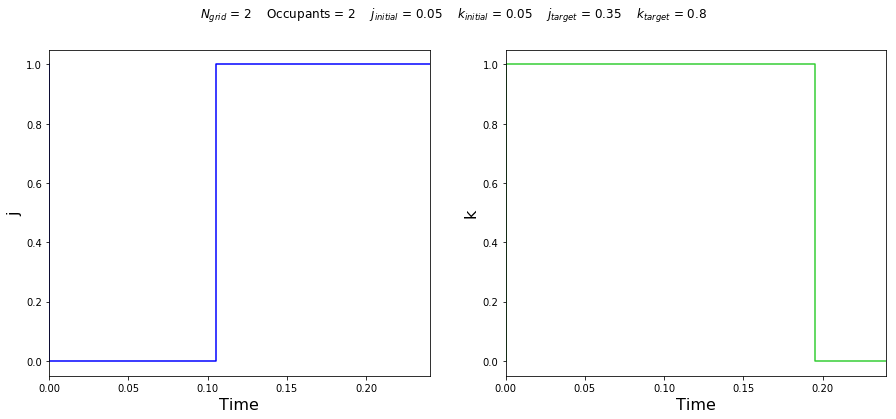

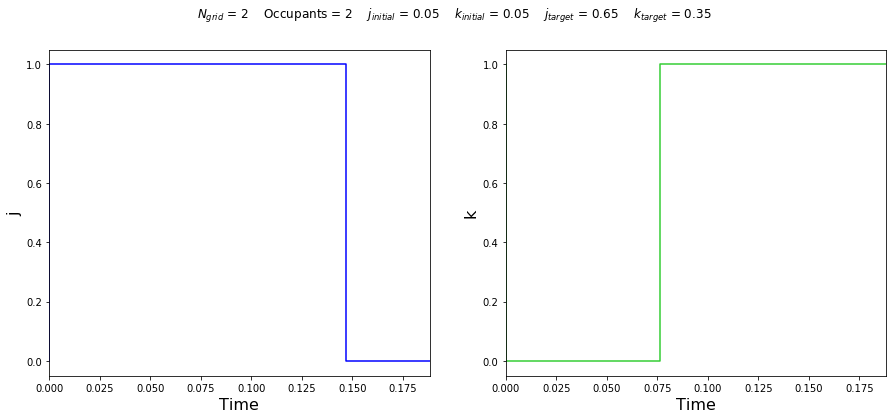

In [61]:
save = False
log = True
cp, rp, gp = True, True, True

group_plot_params =[[0.05,0.05,0.275, 0.725],[0.05,0.05,0.35,0.80],[0.05,0.05,0.65,0.35]]
make_plots(data,group_plot_params, target_comparison_sets,save, log, cp, rp, gp)

In [70]:
ds = get_data_sets(data[0].mcdb_data,ji=0.95,ki=0.05,jt=0.2, kt=0.275)[0]
print(ds.j_protocols[-1])
print(ds.j_jumps[-1])
ds = get_data_sets(data[0].mcdb_data,ji=0.95,ki=0.05,jt=0.425, kt=0.50)[0]
print(ds.j_protocols[-1])
print(ds.j_jumps[-1])

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1


# Looking for scaling across different system sizes

In [51]:
class avg_data_per_init:
    
    def __init__(self, ji,ki,j_jumps,k_jumps,taus, size):
        self.ji          = ji
        self.ki          = ki
        
        self.taus        = taus
        self.tau_avg     = np.mean(taus)
        self.tau_std     = np.std(taus)
        
        self.j_jumps     = j_jumps
        self.j_jumps_avg = np.mean(j_jumps)
        self.j_jumps_std = np.std(j_jumps)
        
        self.k_jumps     = k_jumps
        self.k_jumps_avg = np.mean(k_jumps)
        self.k_jumps_std = np.std(k_jumps)
        self.size        = size

        
class average_data_for_lattice:

    def __init__(self, dim, occ):
        self.dim           = dim
        self.occ           = occ
        self.N             = choose(dim*dim, occ)
        self.taus          = []
        self.tau_avg       = 0
        self.tau_std       = 0
        self.j_jumps       = []
        self.j_jumps_avg   = 0
        self.j_jumps_std   = 0
        self.k_jumps       = []
        self.k_jumps_avg   = 0
        self.k_jumps_std   = 0
        self.data_per_init = []
        self.size_total    = 0
        
    def calc_averages(self):
        for data_group in self.data_per_init:
            self.taus.extend(data_group.taus)
            self.j_jumps.extend(data_group.j_jumps)
            self.k_jumps.extend(data_group.k_jumps)
            
        self.tau_avg     = np.mean(self.taus)
        self.tau_std     = np.std(self.taus)
        self.j_jumps_avg = np.mean(self.j_jumps)
        self.j_jumps_std = np.std(self.j_jumps)
        self.k_jumps_avg = np.mean(self.k_jumps)
        self.k_jumps_std = np.std(self.k_jumps)
        self.size_total  = len(self.taus)

In [54]:
ji_list, ki_list = [0.05, 0.95], [0.05, 0.95]
avg_data = []
for dir_ in data:
    
    av_data_for_lattice = average_data_for_lattice(dir_.dim, dir_.occ)

    for ji in ji_list:
        for ki in ki_list:
            
            mcdb_init = get_data_sets(dir_.mcdb_data, ji=ji, ki=ki,consider_skip=True)
            taus,j_jumps,k_jumps, = [ds.tau_critical for ds in mcdb_init], [ds.j_jumps[-1] for ds in mcdb_init], [ds.k_jumps[-1] for ds in mcdb_init]               
            av_data_for_lattice.data_per_init.append(avg_data_per_init(ji,ki,j_jumps,k_jumps,taus, len(taus)))
            
    av_data_for_lattice.calc_averages()
    avg_data.append(av_data_for_lattice)

In [114]:
print(type("sasda")==str)

True


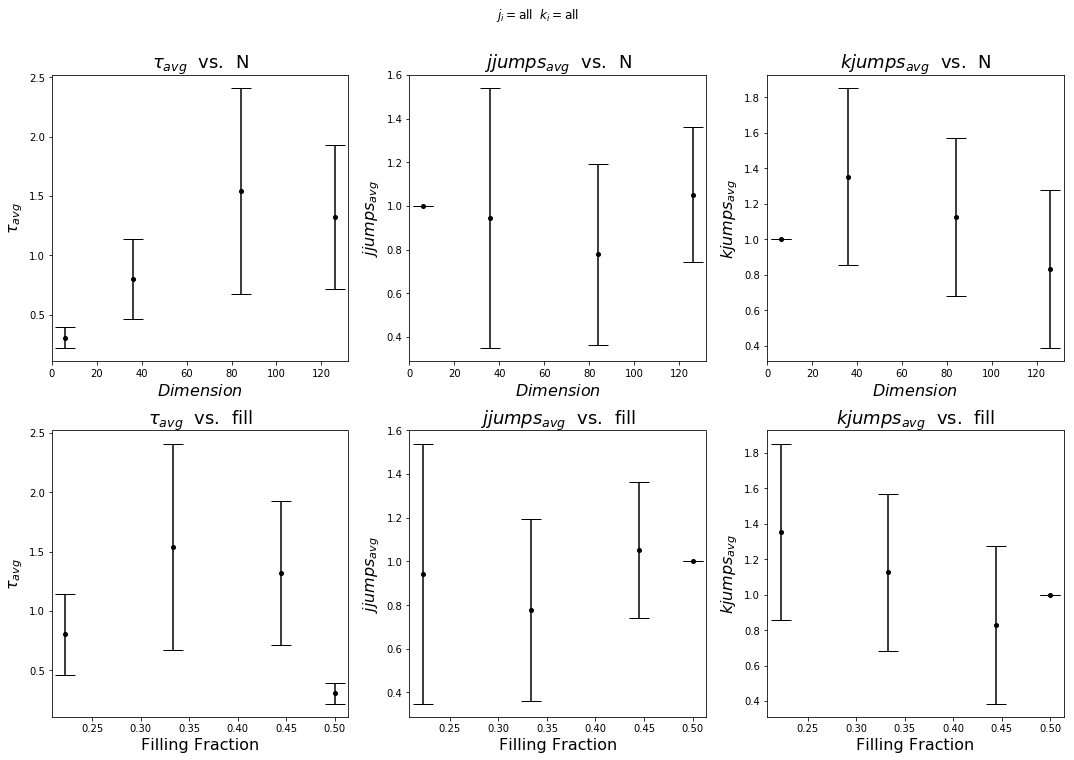

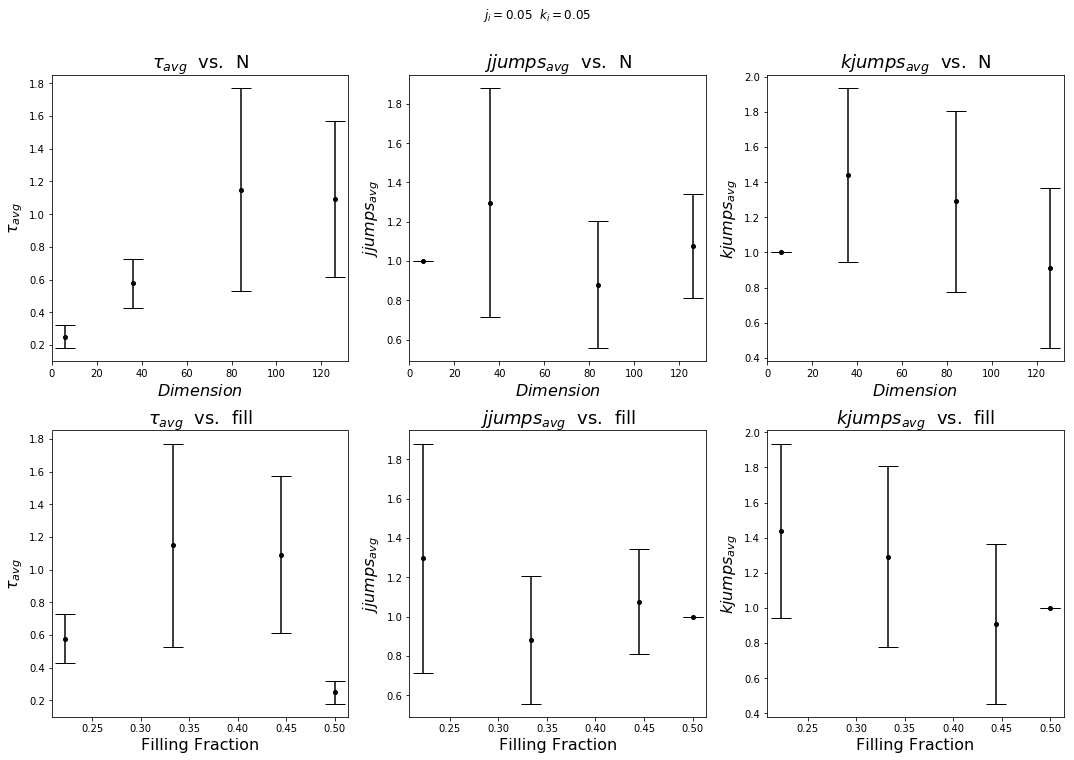

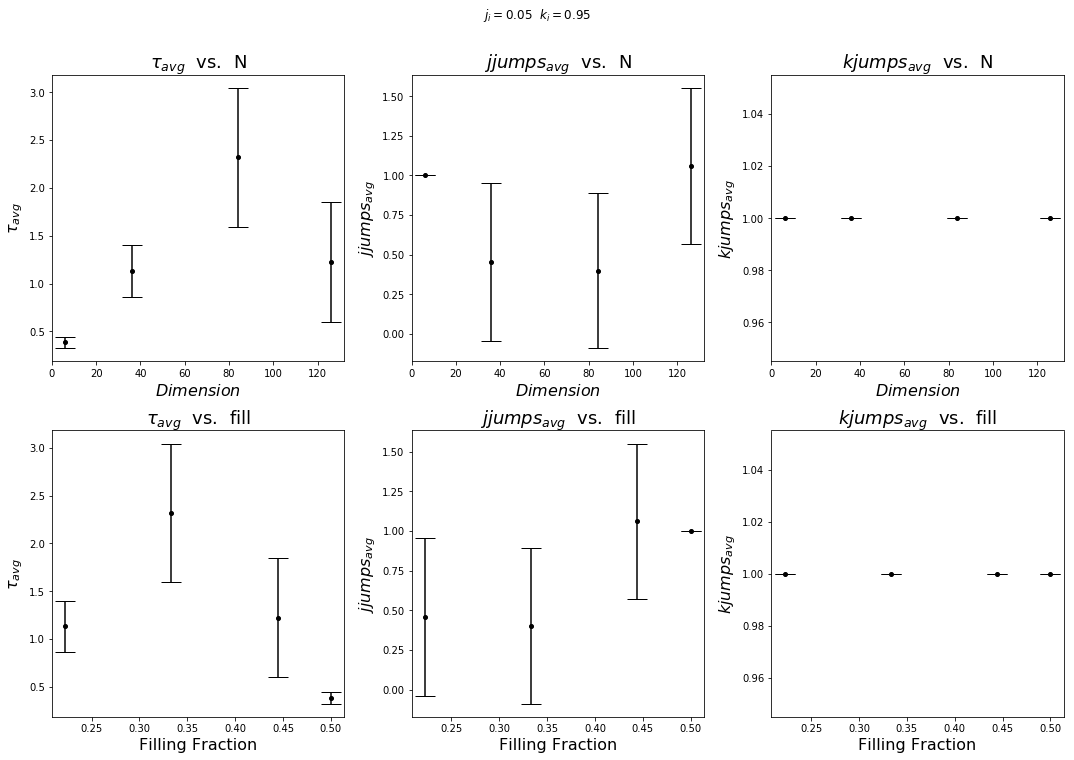

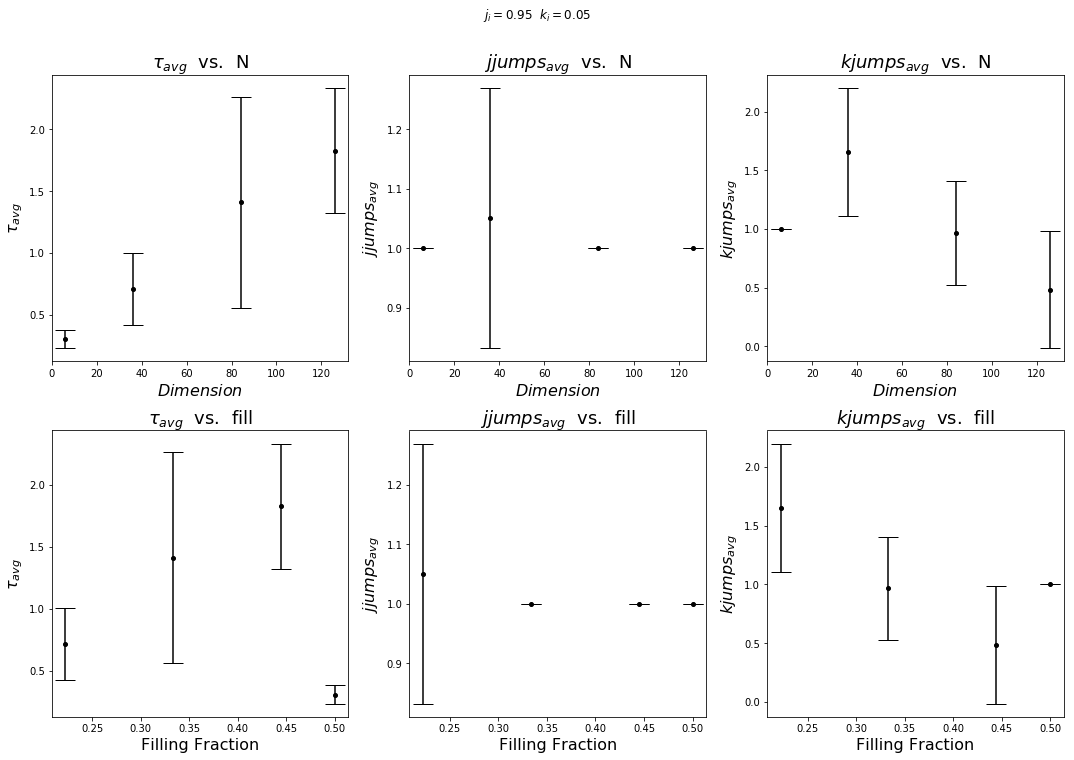

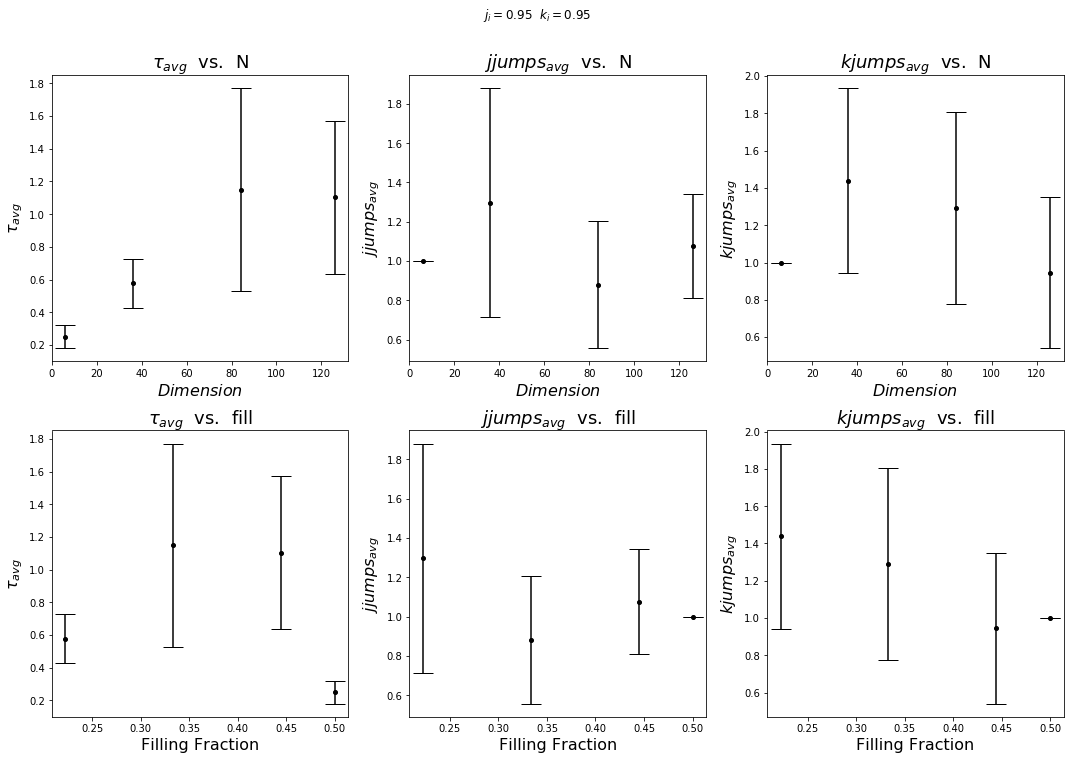

In [122]:
def make_avg_plots(avg_data, ji_ki=["all","all"]):
    
    if(type(ji_ki[0]) == str): data=avg_data
    else:
        data = []
        for dir_ in avg_data:
            for data_per_init in dir_.data_per_init:
                if(data_per_init.ji == ji_ki[0] and data_per_init.ki == ji_ki[1]): data.append(data_per_init)
    
    N,dim,occ = np.array([ds.N for ds in avg_data]),np.array([ds.dim for ds in avg_data]),np.array([ds.occ for ds in avg_data])
    tau_avg, tau_std,j_avg,j_std,k_avg,k_std = [ds.tau_avg for ds in data],[ds.tau_std for ds in data],[ds.j_jumps_avg for ds in data],[ds.j_jumps_std for ds in data],[ds.k_jumps_avg for ds in data],[ds.k_jumps_std for ds in data]

    fig = plt.figure(figsize=(15,10))
    plt.suptitle(r"$j_i=$"+str(ji_ki[0])+"  "+r"$k_i=$"+str(ji_ki[1]),y=1.05)
    
    fig.add_subplot(2, 3, 1)
    plt.title(r"$\tau_{avg}$"+"  vs.  N"),plt.ylabel(r"$\tau_{avg}$"),plt.xlabel(r"$Dimension$")
    plt.errorbar(N,tau_avg, yerr=tau_std,capsize=10,fmt='o', color='black')

    fig.add_subplot(2, 3, 2)
    plt.title(r"$j jumps_{avg}$"+"  vs.  N"),plt.ylabel(r"$j jumps_{avg}$"),plt.xlabel(r"$Dimension$")
    plt.errorbar(N,j_avg, yerr=j_std,capsize=10,fmt='o', color='black')
    
    fig.add_subplot(2, 3, 3)
    plt.title(r"$k jumps_{avg}$"+"  vs.  N"),plt.ylabel(r"$k jumps_{avg}$"),plt.xlabel(r"$Dimension$")
    plt.errorbar(N,k_avg, yerr=k_std,capsize=10,fmt='o', color='black')
    plt.tight_layout(pad=1)

    fig.add_subplot(2, 3, 4)
    plt.title(r"$\tau_{avg}$"+"  vs.  fill"),plt.ylabel(r"$\tau_{avg}$"),plt.xlabel("Filling Fraction")
    plt.errorbar(occ/(dim*dim),tau_avg, yerr=tau_std,capsize=10,fmt='o', color='black')

    fig.add_subplot(2, 3, 5)
    plt.title(r"$j jumps_{avg}$"+"  vs.  fill"),plt.ylabel(r"$j jumps_{avg}$"),plt.xlabel("Filling Fraction")
    plt.errorbar(occ/(dim*dim),j_avg, yerr=j_std,capsize=10,fmt='o', color='black')
    
    fig.add_subplot(2, 3, 6)
    plt.title(r"$k jumps_{avg}$"+"  vs.  fill"),plt.ylabel(r"$k jumps_{avg}$"),plt.xlabel("Filling Fraction")
    plt.errorbar(occ/(dim*dim),k_avg, yerr=k_std,capsize=10,fmt='o', color='black')
    
    plt.tight_layout(pad=1)
    plt.show()

    
make_avg_plots(avg_data)
for ji in ji_list:
    for ki in ki_list: 
        make_avg_plots(avg_data, [ji, ki])

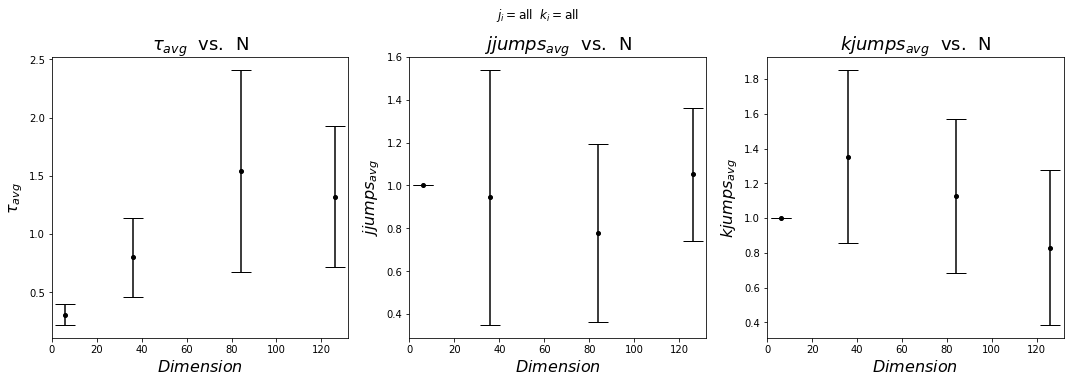

In [105]:
def make_avg_plots(avg_data, ji_ki=["all","all"]):
    
    data = avg_data
    
    N,tau_avg, tau_std,dim,occ = [ds.N for ds in avg_data],[ds.tau_avg for ds in avg_data],[ds.tau_std for ds in avg_data],[ds.dim for ds in avg_data],[ds.occ for ds in avg_data]
    j_avg,j_std,k_avg,k_std = [ds.j_jumps_avg for ds in avg_data],[ds.j_jumps_std for ds in avg_data],[ds.k_jumps_avg for ds in avg_data],[ds.k_jumps_std for ds in avg_data]
    norm = matplotlib.colors.BoundaryNorm(np.arange(1.5,5.5,1), cmap.N)

    fig = plt.figure(figsize=(15,5))
    plt.suptitle(r"$j_i=$"+str(ji_ki[0])+"  "+r"$k_i=$"+str(ji_ki[1]),y=1.05)
    fig.add_subplot(1, 3, 1)
    plt.title(r"$\tau_{avg}$"+"  vs.  N"),plt.ylabel(r"$\tau_{avg}$"),plt.xlabel(r"$Dimension$")
    plt.errorbar(N,tau_avg, yerr=tau_std,capsize=10,fmt='o', color='black')
    plt.scatter(N,tau_avg,norm=norm, marker=8, c=dim,cmap=cmap, s=300,label=r"$N_{grid}$")
    plt.scatter(N,tau_avg,norm=norm, marker=9, c=occ,cmap=cmap, s=300,label=r"$Occupants$")
    plt.colorbar(ticks = np.linspace(2,5,4),label=r"$N_{grid}$"+" and Occupants")
    plt.legend(loc="upper left")
    
    fig.add_subplot(1, 3, 2)
    plt.title(r"$j jumps_{avg}$"+"  vs.  N"),plt.ylabel(r"$j jumps_{avg}$"),plt.xlabel(r"$Dimension$")
    plt.errorbar(N,j_avg, yerr=j_std,capsize=10,fmt='o', color='black')
    plt.scatter(N,j_avg,norm=norm, marker=8, c=dim,cmap=cmap, s=300,label=r"$N_{grid}$")
    #plt.scatter(N,j_avg,norm=norm, marker=9, c=occ,cmap=cmap, s=300,label=r"$Occupants$")
    #plt.colorbar(ticks = np.linspace(2,5,4),label=r"$N_{grid}$"+" and Occupants")
    plt.legend(loc="upper left")
    
    fig.add_subplot(1, 3, 3)
    plt.title(r"$k jumps_{avg}$"+"  vs.  N"),plt.ylabel(r"$k jumps_{avg}$"),plt.xlabel(r"$Dimension$")
    plt.errorbar(N,k_avg, yerr=k_std,capsize=10,fmt='o', color='black')
    #plt.scatter(N,k_avg,norm=norm, marker=8, c=dim,cmap=cmap, s=300,label=r"$N_{grid}$")
    #plt.scatter(N,k_avg,norm=norm, marker=9, c=occ,cmap=cmap, s=300,label=r"$Occupants$")
    #plt.colorbar(ticks = np.linspace(2,5,4),label=r"$N_{grid}$"+" and Occupants")
    plt.legend(loc="upper left")
    plt.tight_layout(pad=1)

    
make_avg_plots(avg_data)

# Object names reminder 

In [64]:
print(data.data_set_list[0].__dict__.keys())

dict_keys(['filepath', 'sim_type', 'dim', 'occ', 'ji', 'ki', 'jt', 'kt', 'initial_e', 'ground_e', 'initial_state', 'target_state', 'init_target_dot_squared', 'num_seeds', 'tau_initial', 'max_tau', 'j_protocols', 'k_protocols', 'tau_array', 'tau_critical', 'best_E_array', 'distance_array', 'best_E_fixed_tau_array', 'total_steps_array', 'time_step_array', 'clock_array', 'overlap_array', 'best_state_array', 'evolved_state_fixed_tau', 'skip', 'j_protocols_reduced', 'k_protocols_reduced', 'tau_extrapolated', 'j_protocols_extrapolated', 'k_protocols_extrapolated', 'j_coeffs', 'k_coeffs', 'j_jumps', 'k_jumps', 'j_char_time', 'j_char_time_over_tau', 'k_char_time', 'k_char_time_over_tau', 'comparisons'])


# Getting the baseline correlation output given a M and N jumps

In [11]:
def protocol_correlation_func2(p1, p2):   
    total_overlap, time_previous, p1_on, p2_on = 0,0,1,1
    combined = sorted(p1+p2)
    for time in combined:
        change = time-time_previous
        if(p1_on == p2_on): total_overlap += change
        if time in p1: p1_on = (p1_on + 1) %2
        if time in p2: p2_on = (p2_on + 1) %2
        time_previous = time
    
    return total_overlap
    



from numpy import random
LOOPS = 10000
M, N,max_jumps = 1, 1,5
info = []
for M in range(1,max_jumps+1,1):
    for N in  range(1,max_jumps+1,1):
        sum = 0
        print(M,N)
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M))
            t2 = list(random.rand(2*N))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M+1))
            t2 = list(random.rand(2*N+1))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M))
            t2 = list(random.rand(2*N+1))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M+1))
            t2 = list(random.rand(2*N))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        info.append([M,N,sum/LOOPS])
        
print(info)

1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
5 1
5 2
5 3
5 4
5 5
[[1, 1, 0.5387556677972538], [1, 2, 0.5323450694644379], [1, 3, 0.52386011264428], [1, 4, 0.5217008778152737], [1, 5, 0.5147194943435496], [2, 1, 0.5309481668099962], [2, 2, 0.5243066372542639], [2, 3, 0.52108035146241], [2, 4, 0.5189683139756341], [2, 5, 0.51592193217535], [3, 1, 0.5270097968763682], [3, 2, 0.5196533459650722], [3, 3, 0.5180855350491896], [3, 4, 0.5157616930313778], [3, 5, 0.5141548790705144], [4, 1, 0.5208964051630999], [4, 2, 0.5174049791784847], [4, 3, 0.516589279089822], [4, 4, 0.5143072755936978], [4, 5, 0.5129547336472938], [5, 1, 0.5172690420472408], [5, 2, 0.5159372205118089], [5, 3, 0.5136185531994105], [5, 4, 0.5113594201523222], [5, 5, 0.5127158514558877]]


In [21]:
sum = 0
for x in range(LOOPS):
    t1 = list(random.rand(2))
    t2 = list(random.rand(2))
    t1.append(1), t2.append(1)
    overlap = protocol_correlation_func2(t1,t2)
    sum += overlap
print(sum/LOOPS)

0.5996372837334853


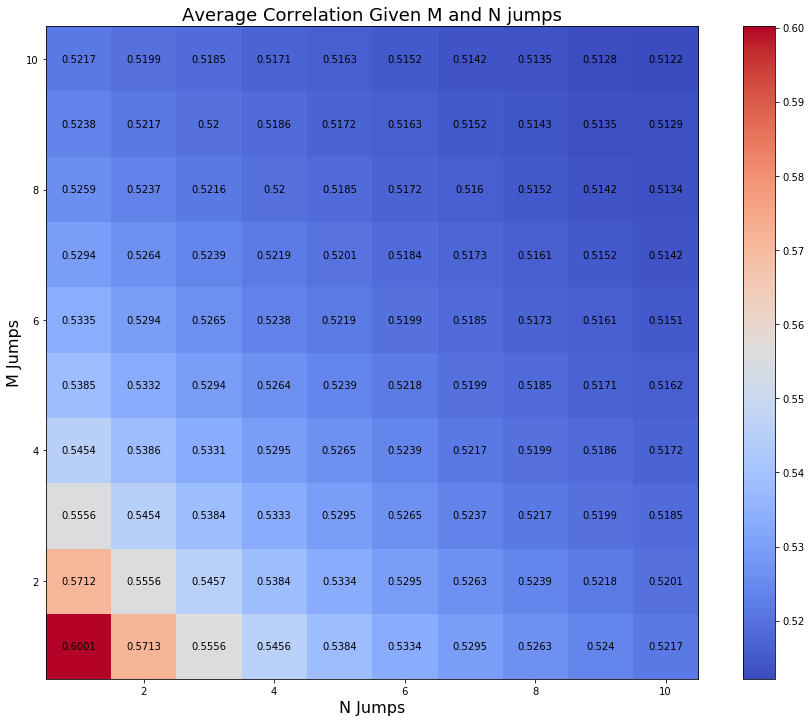

In [34]:

size = 7
data = np.arange(size * size).reshape((size, size))


x_start = 0.5
x_end = max_jumps+0.5
y_start = 0.5
y_end = max_jumps+0.5
size = max_jumps
extent = [x_start, x_end, y_start, y_end]
data = (np.reshape(np.array(info).T[2], (size, size)).T)


# The normal figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
plt.title("Average Correlation Given M and N jumps")
plt.ylabel("M Jumps")
plt.xlabel("N Jumps")
im = ax.imshow(data, extent=extent, origin='lower', interpolation='None', cmap=cmap)

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = data[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, round(label, 4), color='black', ha='center', va='center')

fig.colorbar(im)
#plt.savefig("Figures/corr_vs_jumps_plot.pdf")
plt.show()

# Checking the cost and distance function vs the ratio of j and k for random states

In [101]:
import pandas as pd
f = open("../data/test_cost.txt", "rt")
ji, ki,ratios, jt, kt, cost, dist, states = [],[],[],[],[],[],[],[]


for line in f:
    if "#" in line: continue
    ogline = (line.rstrip())
    line = ogline.split(" ")
    ji.append(float(line[0]))
    ki.append(float(line[1]))
    ratios.append(float(line[2])/float(line[3]))
    jt.append(float(line[2]))
    kt.append(float(line[3]))
    cost.append(float(line[4]))
    dist.append(float(line[5]))
    start = ogline.index("[")
    states.append(literal_eval(ogline[start:]))
    
data = [ji, ki,ratios, jt, kt, cost, dist, states]

In [102]:
for x in range(len(dist)):
    if(abs(jt[x]/kt[x] - ji[x]/ki[x]) == 0): dist[x] = 0
for x in range(len(dist)):
    if dist[x] < 0: print(dist[x], ji[x], ki[x], jt[x], kt[x])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


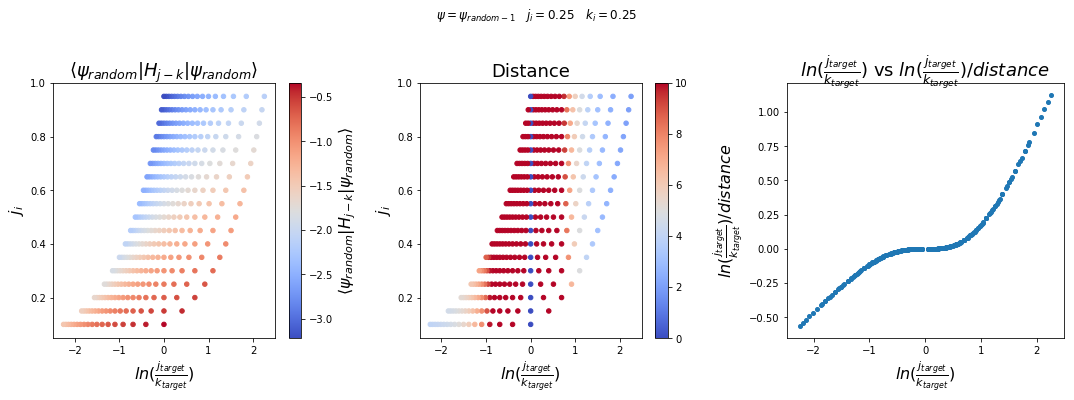

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


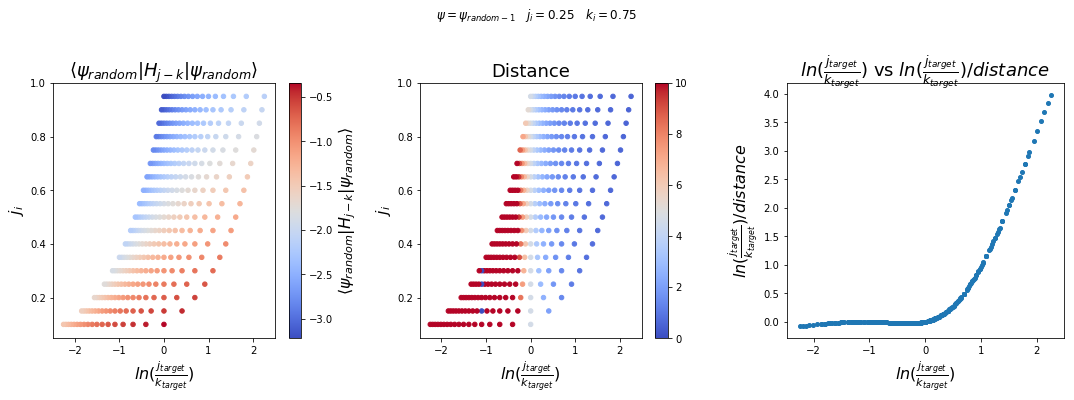

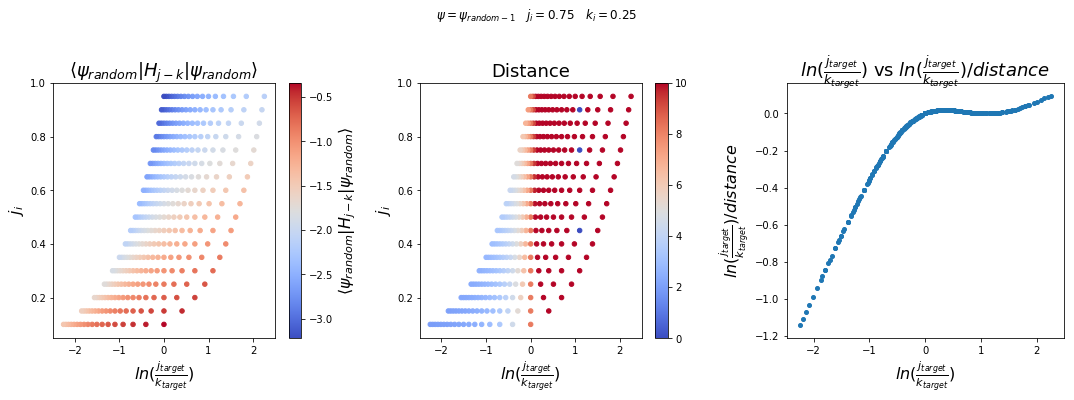

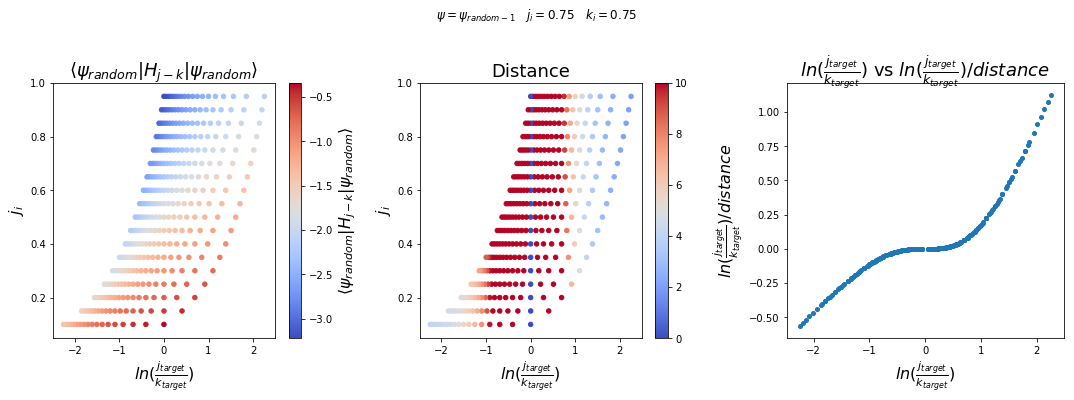

In [123]:
for x in range(2*2):
    data_for_init = []
    for item in data: data_for_init.append(item[x*324:(x+1)*324])
    ji, ki,ratios,jt,kt,cost,dist,states= data_for_init[0],data_for_init[1],data_for_init[2],data_for_init[3],data_for_init[4],data_for_init[5],data_for_init[6],data_for_init[7]
    if(ji[0] != ji[-1] or ki[0] != ki[-1] or states[0] != states[-1] or ratios[0] != ratios[-1]): print("ji ERROR")
    
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(r"$\psi = \psi_{random-1}$"+"   "+r"$j_i = $" +str(ji[0])+ "   "+r"$  k_i = $" + str(ki[0]),y=1.1)
    
    fig.add_subplot(1, 3, 1)
    plt.title(r"$\langle\psi_{random}|H_{j-k}|\psi_{random}\rangle$"),plt.ylabel(r"$j_i$"),plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$")
    plt.scatter(np.log(ratios), jt, s=20, c = cost, cmap=cmap)
    plt.colorbar(label = r"$\langle\psi_{random}|H_{j-k}|\psi_{random}\rangle$")
    
    fig.add_subplot(1, 3, 2)
    plt.title("Distance"),plt.ylabel(r"$j_i$"),plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$")
    plt.scatter(np.log(ratios), jt, s=20, c = dist, cmap=cmap, vmin=0, vmax = 10)
    plt.colorbar()#label = r"$\langle\psi_{random}|H_{j-k}|\psi_{random}\rangle$")
    
    fig.add_subplot(1, 3, 3)
    plt.title(r"$ln(\frac{j_{target}}{k_{target}})$"+" vs "+r"$ln(\frac{j_{target}}{k_{target}})/distance$")
    plt.ylabel(r"$ln(\frac{j_{target}}{k_{target}})/distance$"), plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$")
    plt.scatter(np.log(ratios), np.log(ratios)/np.array(dist))
    plt.tight_layout(pad=1)
    plt.show()

# Plotting dimension over system size and occupancy

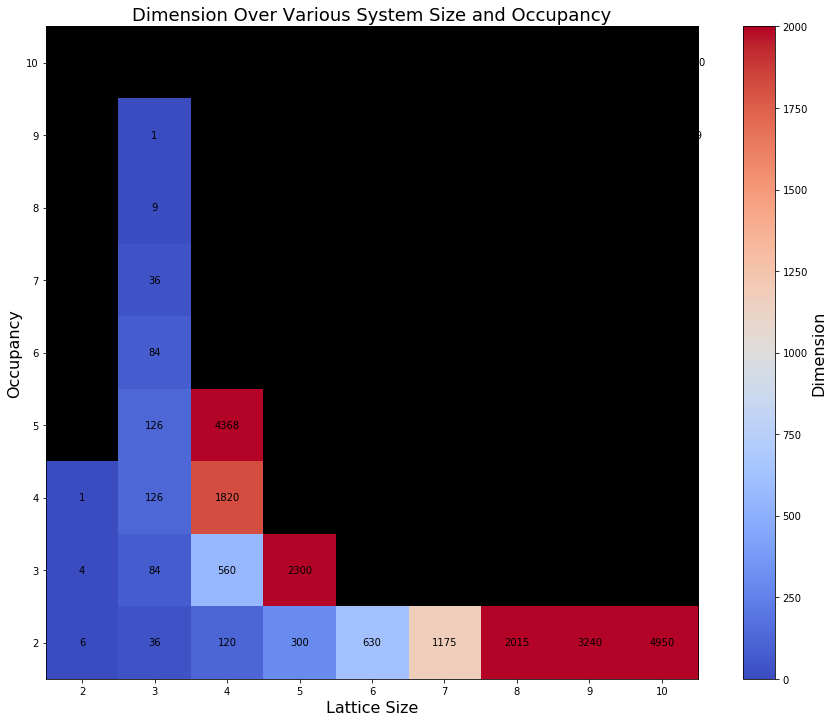

In [237]:
nx_list = [2,3,4,5,6,7,8,9,10]
data = []
for nx in nx_list:
    occ=2
    dimension = 0
    while(occ <= 10):
        dimension = int(choose(nx*nx, occ))
        data.append([nx, occ, dimension])
        occ += 1
nx,occ,N = np.array(data).T[0],np.array(data).T[1],np.array(data).T[2]

x_start = 1.5
x_end = 10.5
y_start = 1.5
y_end = 10.5
size = 9
extent = [x_start, x_end, y_start, y_end]
data = np.reshape(N, (size,size)).T[::-1]
# The normal figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
plt.title("Dimension Over Various System Size and Occupancy")
plt.ylabel("Occupancy"), plt.xlabel("Lattice Size")
plt.yticks([2, 3, 4, 5, 6, 7, 8, 9, 10]),plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10])


masked_data = np.ma.masked_where(data >5000, data)
masked_data = np.ma.masked_where(data == -1, masked_data)
cmap.set_bad(color='black')
im = ax.imshow(masked_data,extent=extent,cmap=cmap, vmin=0, vmax = 2000)



jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = data[8-y_index,x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, round(label, 4), color='black', ha='center', va='center')

fig.colorbar(im, label="Dimension")
plt.savefig("figures/dimension_vs_system.pdf")
plt.show()

# Interpolation

In [54]:
#for the interpolation, we want:
#tau, the time of the nearest neighbor jumps, the best energy
#a nice way to save the old data and add on the new jumps
# input the jumps of two neighbors in either direction

def get_data_set(data_mcbb_whole, dir_, ji, ki, jt, kt):
    index = []
    for x in range(len(data_mcbb_whole[0])):
        conditions = ["ji="+str(ji) in data_mcbb_whole[0][x], 
                      "ki="+str(ki) in data_mcbb_whole[0][x],
                      "jt="+str(jt) in data_mcbb_whole[0][x],
                      "kt="+str(kt) in data_mcbb_whole[0][x],
                      dir_ in data_mcbb_whole[0][x]]
        if(all(conditions)): index.append(x)
    if(len(index) != 1):print("\n\nERROR\n\n")
    else: return data_mcbb_whole[1][index[0]]
    
my_dirs = ['../data/3x3/3_occupants']  
interpolation_info = [[0.05, 0.05, [[0.35,0.95], [0.65, 0.95]], "j"],
                     ]
for interp_set in interpolation_info:
    ji = interp_set[0]
    ki = interp_set[1]
    target1 = interp_set[2][0]
    target2 = interp_set[2][1]
    j_or_k = interp_set[3]
    jt1, kt1 = target1[0], target1[1]
    jt2, kt2 = target2[0], target2[1]
    data1 = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, jt1, kt1)
    data2 = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, jt2, kt2)
    data_to_change = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, (jt1+jt2)/2, (kt1+kt2)/2)

    p1 = get_values(data1, "j_protocols_reduced")[-1]
    p2 = get_values(data2, "j_protocols_reduced")[-1]

    if(len(p1) != len(p2)): print("ERROR, Protocols don't have the same number of jumps")
    new_j_jumps = []
    for t1, t2 in zip(p1, p2):
        new_j_jumps.append((t1+t2)/2)
        
    p1 = get_values(data1, "k_protocols_reduced")[-1]
    p2 = get_values(data2, "k_protocols_reduced")[-1]

    if(len(p1) != len(p2)): print("ERROR, Protocols don't have the same number of jumps")
    new_k_jumps = []
    for t1, t2 in zip(p1, p2):
        new_k_jumps.append((t1+t2)/2)
        
    print("\nji="+str(ji)+" ki="+str(ki)+" jt="+str((jt1+jt2)/2)+" kt="+str((kt1+kt2)/2))
    print("tau="+str(get_values(data_to_change, "tau_array")[-1])+"  best_E="+str(get_values(data_to_change, "best_E_array")[-1]))
#     print("Old j=")
#     print(get_values(data_to_change, "j_protocols_reduced")[-1])
#     print("Old k=")
#     print(get_values(data_to_change, "k_protocols_reduced")[-1])
    print("new Tau = " + str((get_values(data1, "tau_array")[-1]+get_values(data2, "tau_array")[-1])/2))
    print("New j=")
    print(new_j_jumps)
    print("New k=")
    print(new_k_jumps)


ji=0.05 ki=0.05 jt=0.5 kt=0.95
tau=0.532091  best_E=-7.46092
new Tau = 0.5059985
New j=
[0.053341200000000005, 0.207361, 0.2827445, 0.42718500000000004]
New k=
[0.00540225, 0.437875]


#  Gap Plot

In [ ]:
def plot_gap():
    filepath = '../data/gap.txt'
    j, k, gap = [],[],[]
    
    for line in open(filepath, "rt"):     
        line = line.rstrip("\n")
        if line.startswith('gap'): gap.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('j'):   j.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('k'):   k.append(literal_eval((line.split('=')[-1]).replace(" ", "")))

    plt.figure()
    plt.ylabel("k")
    plt.xlabel("j")
    plt.ylim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.scatter(j, k, c=gap, cmap = cmap, s = 10, alpha=0.7)
    cbar = plt.colorbar(label = 'gap')
    #plt.scatter(0.1, 0.1, s = 100, c = 'pink', label = 'initial')
    #plt.scatter(1, 1, s = 100, c = 'black', label = 'target')
    #plt.legend()
    plt.savefig("../data/gap_plot_3x3_4_occ.pdf")
    plt.show()

plot_gap()

# Creating the Directory Structure

In [3]:
max_lattice_size = 6
'''Rectangular Lattice
for n in range(2,max_lattice_size+1):
    for m in range(2,max_lattice_size+1):
        for x in  range(2, m*n-1):
            if(m>=n): #preventing creation of both mxn and nxm
                dir = '../data/'+str(n)+'x'+str(m)+'/'+str(x)+'_occupants'
                if not os.path.exists(dir):
                    os.makedirs(dir)
'''
#Square Lattice
for n in range(2,max_lattice_size+1):
    for x in  range(2, n*n-1):
        dir = '../data/'+str(n)+'x'+str(n)+'/'+str(x)+'_occupants'
        if not os.path.exists(dir):
            os.makedirs(dir)            

In [13]:
for my_dir in my_dirs:
    for filepath in glob.iglob(my_dir + '*.txt'):
        reading_file = open(filepath, "r")

        new_file_content = ""

        for line in reading_file:     
            stripped_line = line.strip()
            if "best_E" in line: new_line = stripped_line.replace("best_E", "best_mc_result")
            else: new_line = stripped_line
            new_file_content += new_line +"\n"
        reading_file.close()

        writing_file = open(filepath, "w")
        writing_file.write(new_file_content)
        writing_file.close()